# Содержание
- ### 1. Импорт библиотек
- ### 2. Загрузка данных
- ### 3. Анализ букмекеров
- ### 4. Анализ и обработка данных о противостояниях
- ### 5. Feature engineering
- ### 6. Обучение предиктивной модели
- ### 7. Создание общеq матрицы матчей
- ### 8. Предсказание результатов матчей
- ### 9. Подготовка финального csv для дашборда

# 1. Импорт библиотек

In [125]:
# Data Processing
import pandas as pd
from pandas import isnull, value_counts
import numpy as np
# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from itertools import permutations
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, mean_squared_error
from sklearn.utils.class_weight import compute_class_weight
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


# 2. Загрузка данных (изменить пути на актуальные)

In [70]:
df = pd.read_csv('/data/bk_pred.csv') # таблица с предсказаниями букмекеров - предлагаю использовать как основную
df_team_atr = pd.read_csv('/data/team_attr.csv') #Таблица с атрибутами команд
df_uefa_CL = pd.read_csv('/data/uefacompetitionresults.csv',sep=';')  #Таблица с матчами под эгидой УЕФА (европейские межлиговые матчи)
df_league_strenght = pd.read_csv('/data/uefa_rating.csv')


# 3. Анализ данных

### 3.1 Проверяем как сильно отличаются вероятности конкретного исхода по мнению разных букмекеров

Text(0.5, 1.0, 'Разница между вероятностями на победу гостевой команды')

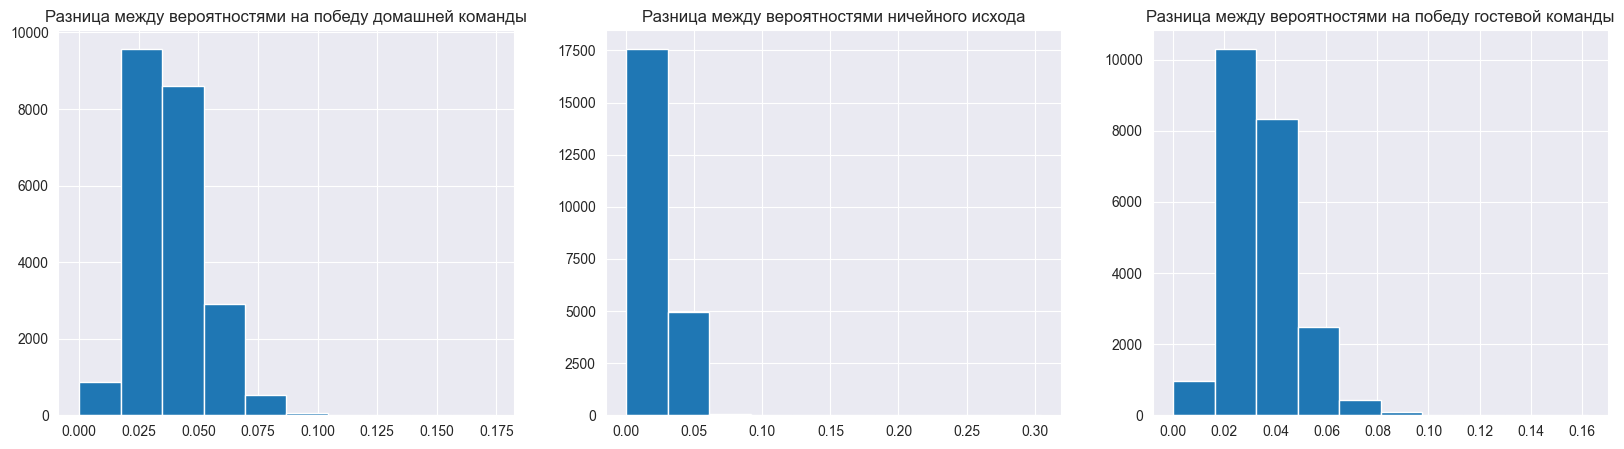

In [71]:
bookmakers_home_pct = ['b365_home_pct', 'bw_home_pct',
       'iw_home_pct', 'lb_home_pct', 'ps_home_pct', 'wh_home_pct',
       'sj_home_pct',  'vc_home_pct','gb_home_pct', 'bs_home_pct']

bookmakers_draw_pct = ['b365_draw_pct',  'bw_draw_pct',  'iw_draw_pct',
       'lb_draw_pct', 'ps_draw_pct','wh_draw_pct',  'sj_draw_pct',
       'vc_draw_pct',  'gb_draw_pct', 'bs_draw_pct']

bookmakers_away_pct = [
       'b365_away_pct', 'bw_away_pct','iw_away_pct',  'lb_away_pct',
       'ps_away_pct', 'wh_away_pct', 'sj_away_pct',  'vc_away_pct',
       'gb_away_pct',  'bs_away_pct']

df['delta_minmax_home_pct'] = df[bookmakers_home_pct].max(axis=1) - df[bookmakers_home_pct].min(axis=1)
df['delta_minmax_draw_pct'] = df[bookmakers_draw_pct].max(axis=1) - df[bookmakers_draw_pct].min(axis=1)
df['delta_minmax_away_pct'] = df[bookmakers_away_pct].max(axis=1) - df[bookmakers_away_pct].min(axis=1)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].hist(df['delta_minmax_home_pct'], bins=10)
axes[0].set_title('Разница между вероятностями на победу домашней команды')
axes[1].hist(df['delta_minmax_draw_pct'], bins=10)
axes[1].set_title('Разница между вероятностями ничейного исхода')
axes[2].hist(df['delta_minmax_away_pct'], bins=10)
axes[2].set_title('Разница между вероятностями на победу гостевой команды')

### 3.1 ВЫВОД (по отличию вероятности конкретного исхода от разных бк)
Так как в большинстве случаев разница в вероятности конкретного исхода не сильно отличается, возьмем среднее значение из ненулевых


### 3.2 Оценка полноты данных по букмекерам

In [72]:
df['mean_home_pct'] = df[bookmakers_home_pct].mean(axis=1, skipna=True)
df['mean_draw_pct'] = df[bookmakers_draw_pct].mean(axis=1, skipna=True)
df['mean_away_pct'] = df[bookmakers_away_pct].mean(axis=1, skipna=True)

print('Количество матчей на которые вообще нет прогноза на победу гостей от букмекеров: ', df['mean_away_pct'].isnull().sum())
print('Количество матчей на которые вообще нет прогноза на ничью от букмекеров: ', df['mean_home_pct'].isnull().sum())
print('Количество матчей на которые вообще нет прогноза на победу хозяев от букмекеров: ', df['mean_away_pct'].isnull().sum())

Количество матчей на которые вообще нет прогноза на победу гостей от букмекеров:  3382
Количество матчей на которые вообще нет прогноза на ничью от букмекеров:  3382
Количество матчей на которые вообще нет прогноза на победу хозяев от букмекеров:  3382


In [73]:
# Проверим как матчи без прогноза от букмекеров распределены по Лигам
df_without_pcts = df[df['mean_away_pct'].isna()]
df_without_pcts.info()
df_without_pcts['country_name'].value_counts() #Смотрим количество строк с отсутствующими значениями от букмекеров по странам
df['country_name'].value_counts() #Смотрим общее количество строк по странам

<class 'pandas.core.frame.DataFrame'>
Index: 3382 entries, 166 to 25978
Data columns (total 60 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   season                 3382 non-null   object 
 1   date                   3382 non-null   object 
 2   home_team_goal         3382 non-null   int64  
 3   away_team_goal         3382 non-null   int64  
 4   home_overall_rating    3139 non-null   float64
 5   away_overall_rating    3139 non-null   float64
 6   home_team_long_name    3382 non-null   object 
 7   home_team_short_name   3382 non-null   object 
 8   away_team_long_name    3382 non-null   object 
 9   away_team_short_name   3382 non-null   object 
 10  shoton_cnt             9 non-null      float64
 11  shotoff_cnt            9 non-null      float64
 12  foulcommit_cnt         9 non-null      float64
 13  card_cnt               113 non-null    float64
 14  cross_cnt              9 non-null      float64
 15  corner

country_name
England        3040
France         3040
Spain          3040
Italy          3017
Germany        2448
Netherlands    2448
Portugal       2052
Poland         1920
Scotland       1824
Belgium        1728
Switzerland    1422
Name: count, dtype: int64

### 3.2 ВЫВОД (по полноте данных по бк)
Для чемпионата Польши и Швейцарии у нас нет данных от букмекеров

### 3.3 Проверка точности предсказания букмекера

In [74]:
# Для начала определяем победителя
# Создаем условия для определения победителя
conditions = [
    df['home_team_goal'] > df['away_team_goal'],  # Победа домашней команды
    df['home_team_goal'] < df['away_team_goal']   # Победа гостевой команды
]

choices = [1, 2]  # Соответствующие значения для условий: 1 - победа хозяев, 2 - победа гостей, 0 - ничья

# Применяем условия с помощью np.select
df['who_win'] = np.select(conditions, choices, default=0)  # По умолчанию ничья (0)

In [75]:
# Добавим столбец попадания букмекеров (1 - попадание, 0 - промах)
# Создаем временный DataFrame с вероятностями
probs = df[['mean_home_pct', 'mean_draw_pct', 'mean_away_pct']].copy()

# Заменяем NaN на -1 для корректной работы idxmax
probs_filled = probs.fillna(-1)

# Находим столбец с максимальной вероятностью
df['bk_pred_col'] = probs_filled.idxmax(axis=1)

# Для строк, где все значения были NaN, устанавливаем специальное значение
all_na_mask = probs.isna().all(axis=1)
df.loc[all_na_mask, 'bk_pred_col'] = 'unknown'

# Преобразуем названия столбцов в числовые значения исхода
df['bk_pred'] = df['bk_pred_col'].replace({
    'mean_home_pct': 1,
    'mean_draw_pct': 0,
    'mean_away_pct': 2,
    'unknown': -1
}).astype('int8')

# Для строк с отсутствующими предсказаниями устанавливаем NaN
df.loc[df['bk_pred'] == -1, 'bk_pred'] = np.nan

# Удаляем временный столбец
df.drop('bk_pred_col', axis=1, inplace=True)

# Сравниваем с фактическим исходом (только для матчей с предсказаниями)
df['bk_correct'] = np.nan
valid_mask = df['bk_pred'].notna()
df.loc[valid_mask, 'bk_correct'] = (df.loc[valid_mask, 'bk_pred'] == df.loc[valid_mask, 'who_win']).astype(int)

# Общая точность предсказаний букмекеров
accuracy = df['bk_correct'].mean()
print(f"Точность предсказаний букмекеров: {accuracy:.2%}")

Точность предсказаний букмекеров: 53.25%


/var/folders/9y/8j877ld57vjfw5zsr25mjc_c0000gn/T/ipykernel_44869/953369732.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['bk_pred'] = df['bk_pred_col'].replace({


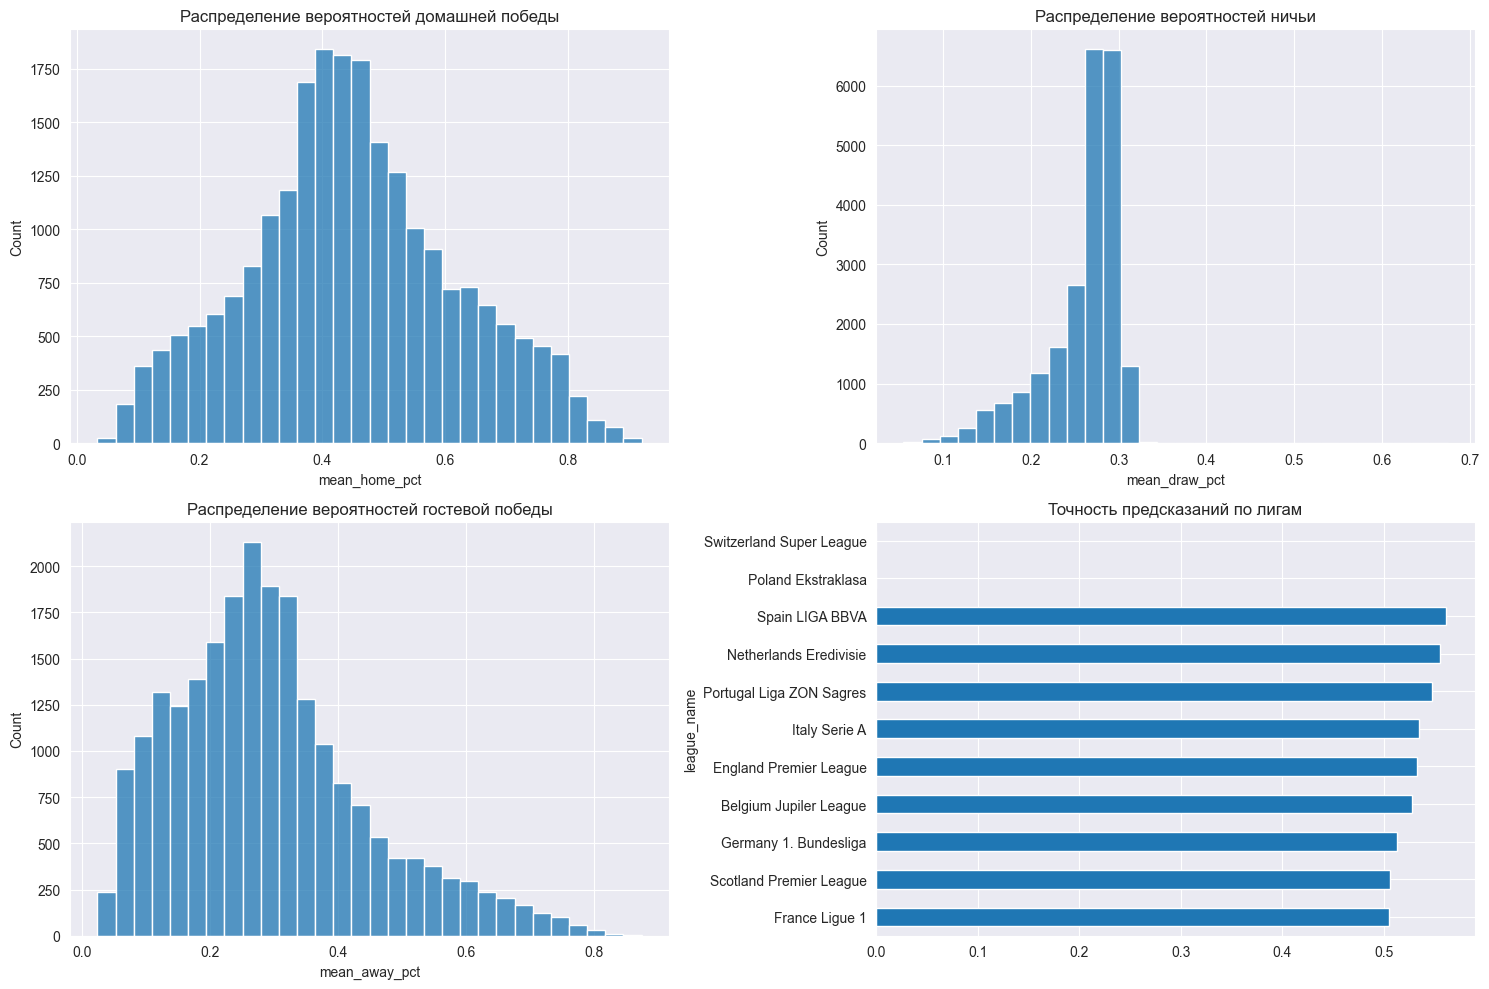

In [76]:
# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Распределение вероятностей
sns.histplot(data=df, x='mean_home_pct', bins=30, ax=axes[0,0], label='Домашняя победа')
sns.histplot(data=df, x='mean_draw_pct', bins=30, ax=axes[0,1], label='Ничья')
sns.histplot(data=df, x='mean_away_pct', bins=30, ax=axes[1,0], label='Гостевая победа')
axes[0,0].set_title('Распределение вероятностей домашней победы')
axes[0,1].set_title('Распределение вероятностей ничьи')
axes[1,0].set_title('Распределение вероятностей гостевой победы')

# Точность по лигам
league_accuracy = df.groupby('league_name')['bk_correct'].mean().sort_values()
league_accuracy.plot(kind='barh', ax=axes[1,1])
axes[1,1].set_title('Точность предсказаний по лигам')

plt.tight_layout()
plt.show()
pd.set_option('display.max_columns', None)

### 3.3 ВЫВОД ( точности предсказания бк)
Первые три гистограммы - распределение предсказаний букмекеров

Если коротко П1 - 40-60%, П2 - 20-40%, Н - 20-30%, что в целом описывает предполагаемое преимущество домашней команды перед гостевой. Вариант с ничьей является менее вероятным чем победа одной из команд.

Точность предсказания в разных Лигах варьируется от 50% до 65%. со средней точностью 53.25%. Так как есть три варианта исходов, то рандом даст нам 33%, то есть предсказание букмекеров работает, хоть и не очень хорошо. Точность соответствует типичной точности профессиональных прогнозов в футболе.

Общий вывод - предсказания букмекеров стоит использовать для предсказания результатов для тех лиг, где у нас есть данные по ним. Для Польши и Швейцарии надо разрабатывать другую модель. Проблема в том, что основные количественные показатели для этих лиг у нас тоже отсутствуют.

# 4. Анализ и обработка атрибутов команд.

### 4.1 Проверяем и убираем пропуски в атрибутах

In [77]:
df_team_atr.isnull().sum() #смотрим на количество пропусков

match_api_id                            0
season                                  0
date                                    0
home_team_goal                          0
away_team_goal                          0
home_team                               0
away_team                               0
league                                  0
country                                 0
home_buildupplayspeed                6063
home_buildupplaypassing              6063
home_buildupplaydribbling           20105
home_chancecreationpassing           6063
home_chancecreationshooting          6063
home_chancecreationcrossing          6063
home_defencepressure                 6063
home_defenceaggression               6063
home_defenceteamwidth                6063
home_buildupplayspeedclass              0
home_buildupplaypositioningclass     6063
away_buildupplayspeed                6055
away_buildupplaypassing              6055
away_buildupplaydribbling           20104
away_chancecreationpassing        

In [78]:
df_team_atr_without_atr = df_team_atr[df_team_atr['away_buildupplayspeed'].isna()]
# выделяем строки с пропусками, чтобы посмотреть структуру пропусков по странам (выбрал "билдапплейспид" потому что там примерно одинаковые пропуски в целом по матчу).
df_team_atr_without_atr['country'].value_counts()

country
England        644
France         628
Italy          628
Netherlands    620
Spain          610
Belgium        581
Portugal       569
Germany        514
Scotland       468
Poland         462
Switzerland    331
Name: count, dtype: int64

### 4.1 ВЫВОД
Пропуски распределены по странам равномерно, так что можно заполнить средними показателями по названию команды. Или даже просто рассчитать средний значения для каждой команды с точки зрения игры дома и в гостях, так как в конечной модели у нас уже не будет этих данных. То есть наша модель должна иметь представления о средних показателях каждой команды, которые мы должны сейчас рассчитать.


In [79]:
df_team_atr.drop(['away_buildupplaydribbling', 'home_buildupplaydribbling'], axis=1, inplace=True) #Удаляем аттрибуты с наибольшим кол-вом пропусков

In [80]:
atr_col = [col for col in df_team_atr.columns if col.startswith(('home_', 'away_')) and df_team_atr[col].dtype in ['float64', 'int64', 'float32', 'int32']] # выделение всех атрибутов в отдельный список
home_atr = [col for col in atr_col if col.startswith('home_')]
away_atr = [col for col in atr_col if col.startswith('away_')] # разделение атрибутов на домашние и гостевые команды

for col in home_atr:
    df_team_atr[col] = df_team_atr.groupby('home_team')[col].transform(lambda x: x.fillna(x.mean())) # домашние команды заполняем средним значением
for col in away_atr:
    df_team_atr[col] = df_team_atr.groupby('away_team')[col].transform(lambda x: x.fillna(x.mean())) # гостевые команды заполняем средним значением

df_team_atr[atr_col] = df_team_atr[atr_col].fillna(df_team_atr[atr_col].mean()) # заполняем оставшиеся пропуски

In [81]:
rating = [col for col in df.columns if col.startswith('home_over') or col.startswith('away_over')]
home_r = [col for col in rating if col.startswith('home')]
away_r = [col for col in rating if col.startswith('away')]
for col in home_r:
    df[col] = df.groupby('home_team_long_name')[col].transform(lambda x: x.fillna(x.mean()))
for col in away_r:
    df[col] = df.groupby('away_team_long_name')[col].transform(lambda x: x.fillna(x.mean())) #заполняем пропуски в рейтинге средним значением по команде

# 5. Feature engineering
### Что должно получиться?
- В итоговом дашборде можно будет брать лигу и команду в ней и другую команду.
- На дашборд нужно вывести 2-3 ключевые характеристики, которые сможет выбрать пользователь
- Результатом должно стать:
    1. на первом уровне результат матча (П1,П2,Н)
    2. на втором уровне вероятности различных итогов (можно в процентах, можно коэфф как у бк)
    3. на третьем уровне вероятности исходов для команд из разных соревнований

### Что надо предусмотреть? и как это реализовать?
- Играет команда дома или в гостях. Решение: создаем матрицу где каждая команда играет с каждой.
- Общий рейтинг команды
- Форму команды (последние 5 матчей), среднее значения до события и скользящее среднее за последние 5 матчей
- Средние значения атрибутов команды или их отношения
- Коэффициент силы Лиги

### Как дашборд будет подбирать результаты?
- Создадим матрицу где все команды играют со всеми, заполним для них последние актуальные атрибуты и дадим нашей модели заполнить ее

In [82]:
df_merge = pd.merge(df, df_team_atr, on = 'match_api_id')

In [83]:
df_merge.columns

Index(['season_x', 'date_x', 'home_team_goal_x', 'away_team_goal_x',
       'home_overall_rating', 'away_overall_rating', 'home_team_long_name',
       'home_team_short_name', 'away_team_long_name', 'away_team_short_name',
       'shoton_cnt', 'shotoff_cnt', 'foulcommit_cnt', 'card_cnt', 'cross_cnt',
       'corner_cnt', 'possession_cnt', 'b365_home_pct', 'b365_draw_pct',
       'b365_away_pct', 'bw_home_pct', 'bw_draw_pct', 'bw_away_pct',
       'iw_home_pct', 'iw_draw_pct', 'iw_away_pct', 'lb_home_pct',
       'lb_draw_pct', 'lb_away_pct', 'ps_home_pct', 'ps_draw_pct',
       'ps_away_pct', 'wh_home_pct', 'wh_draw_pct', 'wh_away_pct',
       'sj_home_pct', 'sj_draw_pct', 'sj_away_pct', 'vc_home_pct',
       'vc_draw_pct', 'vc_away_pct', 'gb_home_pct', 'gb_draw_pct',
       'gb_away_pct', 'bs_home_pct', 'bs_draw_pct', 'bs_away_pct',
       'home_team_api_id', 'away_team_api_id', 'league_id', 'league_name',
       'country_id', 'country_name', 'match_api_id', 'delta_minmax_home_pct',
 

In [84]:
df_merge.drop(df_merge[['season_y', 'date_y', 'home_team_goal_y', 'away_team_goal_y',
       'home_team', 'away_team', 'league', 'country']], inplace = True, axis = 1)

#### 5.1 Метрики для оценки формы команды
Ниже мы хотим:
1. добавить столбец 'название_атрибута_current_avg', в котором будут считаться средние показатели атрибутов от начала наблюдений до текущего матча
2. добавить столбец 'название атрибута_last_10_matches', в котором будет среднее значение за последние 10 матчей

Мы хотим, чтобы скользящее среднее и накопительное среднее собирались со всех матчей команды (вне зависимости от того, играла она дома или в гостях), а у нас данные с префиксами для домашних и гостевых игр.

Поэтому мы создаем две таблицы в формате дата/ид_команды/атрибуты где в одной у нас будут все данные по домашней команде, в другой по гостеваой, потом мы их объединим и получим длинный список матчей, где в одной строке одна команда и ее атрибуты с конкретного матча

+ для каждого атрибута надо будет убрать префикс, чтобы мы могли их слить в один столбец в будущем

In [86]:
# Копипруем, чтобы ничего не поломать
df_temp = df_merge.copy()

# Создаем список всех атрибутов (без префиксов home/away), чтобы не прописывать все каждый раз, используем {attr}' for attr in base_attributes, приставив перед аттр хоум или эвей.
base_attributes = [
    'buildupplayspeed', 'buildupplaypassing', 'chancecreationpassing',
    'chancecreationshooting', 'chancecreationcrossing', 'defencepressure',
    'defenceaggression', 'defenceteamwidth']



In [87]:
# создаем таблицу с домашней командой и ее атрибутами
home_matches = df_temp[['date_x', 'home_team_api_id'] + [f'home_{attr}' for attr in base_attributes]].copy()
home_matches = home_matches.rename(columns={'home_team_api_id': 'team_api_id'}) # унифицируем, чтобы все можно было найти потом по айди
for attr in base_attributes:
    home_matches[attr] = home_matches[f'home_{attr}']
    home_matches = home_matches.drop(columns=[f'home_{attr}']) 

# создаем таблицу с гостевой командой и ее атрибутами
away_matches = df_temp[['date_x', 'away_team_api_id'] + [f'away_{attr}' for attr in base_attributes]].copy()
away_matches = away_matches.rename(columns={'away_team_api_id': 'team_api_id'}) # унифицируем, чтобы все можно было найти потом по айди
for attr in base_attributes:
    away_matches[attr] = away_matches[f'away_{attr}']
    away_matches = away_matches.drop(columns=[f'away_{attr}'])

# Объединяем домашние и гостевые матчи
all_matches = pd.concat([home_matches, away_matches], ignore_index=True)
all_matches = all_matches.sort_values(['team_api_id', 'date_x'])

In [88]:
# Для каждой команды рассчитываем скользящие статистики через expanding и rolling
for attr in base_attributes:
    # Накопленное среднее (исключая текущий матч)
    all_matches[f'{attr}_current_avg'] = all_matches.groupby('team_api_id')[attr]\
        .transform(lambda x: x.expanding().mean().shift(1))

    # Среднее за последние 10 матчей (исключая текущий матч)
    all_matches[f'{attr}_last_10_matches'] = all_matches.groupby('team_api_id')[attr]\
        .transform(lambda x: x.rolling(window=10, min_periods=1).mean().shift(1))



Теперь надо добавить префиксы обратно, чтобы не ломать структуру изначального датафрейма

In [89]:

# Создаем словари для переименования столбцов

# Для домашних команд
home_rename_dict = {'team_api_id': 'home_team_api_id'}

# Добавляем переименования для current_avg атрибутов
for attr in base_attributes:
    home_rename_dict[f'{attr}_current_avg'] = f'home_{attr}_current_avg'

# Добавляем переименования для last_10_matches атрибутов
for attr in base_attributes:
    home_rename_dict[f'{attr}_last_10_matches'] = f'home_{attr}_last_10_matches'

# Применяем переименование для домашних команд
home_stats = all_matches.rename(columns=home_rename_dict)

# Для гостевых команд
away_rename_dict = {'team_api_id': 'away_team_api_id'}

# Добавляем переименования для current_avg атрибутов
for attr in base_attributes:
    away_rename_dict[f'{attr}_current_avg'] = f'away_{attr}_current_avg'

# Добавляем переименования для last_10_matches атрибутов
for attr in base_attributes:
    away_rename_dict[f'{attr}_last_10_matches'] = f'away_{attr}_last_10_matches'

# Применяем переименование для гостевых команд
away_stats = all_matches.rename(columns=away_rename_dict)



In [90]:
# Удаляем конфликтующие столбцы из df_temp перед объединением
columns_to_drop = [f'home_{attr}_current_avg' for attr in base_attributes] + \
                  [f'home_{attr}_last_10_matches' for attr in base_attributes] + \
                  [f'away_{attr}_current_avg' for attr in base_attributes] + \
                  [f'away_{attr}_last_10_matches' for attr in base_attributes]

# Оставляем только те столбцы, которые действительно есть в df_temp
existing_columns_to_drop = [col for col in columns_to_drop if col in df_temp.columns]
df_temp = df_temp.drop(columns=existing_columns_to_drop)

# Теперь выполняем объединение
df_temp = df_temp.merge(
    home_stats[['date_x', 'home_team_api_id'] +
               [f'home_{attr}_current_avg' for attr in base_attributes] +
               [f'home_{attr}_last_10_matches' for attr in base_attributes]],
    on=['date_x', 'home_team_api_id'],
    how='left'
)

df_temp = df_temp.merge(
    away_stats[['date_x', 'away_team_api_id'] +
               [f'away_{attr}_current_avg' for attr in base_attributes] +
               [f'away_{attr}_last_10_matches' for attr in base_attributes]],
    on=['date_x', 'away_team_api_id'],
    how='left'
)


Когда мы исользовали expanding().mean().shift(1) и rolling(10).mean().shift(1), шифт отвечал за то, чтобы убрать текущий результат, поэтому у нас нет данных для первых матчей каждой команды. Их просто заполняем прямым значением из атрибутов.

In [91]:
# Заполняем пропущенные значения (для первых матчей команд)
for attr in base_attributes:
    df_temp[f'home_{attr}_current_avg'] = df_temp[f'home_{attr}_current_avg'].fillna(df_temp[f'home_{attr}'])
    df_temp[f'home_{attr}_last_10_matches'] = df_temp[f'home_{attr}_last_10_matches'].fillna(df_temp[f'home_{attr}'])
    df_temp[f'away_{attr}_current_avg'] = df_temp[f'away_{attr}_current_avg'].fillna(df_temp[f'away_{attr}'])
    df_temp[f'away_{attr}_last_10_matches'] = df_temp[f'away_{attr}_last_10_matches'].fillna(df_temp[f'away_{attr}'])


In [92]:
df_merge = df_temp  # возвращаемся обратно в df_merge
df_merge.drop(df_merge[['home_buildupplayspeed', 'home_buildupplaypassing',
       'home_chancecreationpassing', 'home_chancecreationshooting',
       'home_chancecreationcrossing', 'home_defencepressure',
       'home_defenceaggression', 'home_defenceteamwidth',
       'home_buildupplayspeedclass', 'home_buildupplaypositioningclass',
       'away_buildupplayspeed', 'away_buildupplaypassing',
       'away_chancecreationpassing', 'away_chancecreationshooting',
       'away_chancecreationcrossing', 'away_defencepressure',
       'away_defenceaggression', 'away_defenceteamwidth',
       'away_buildupplayspeedclass', 'away_buildupplaypositioningclass']], axis=1, inplace=True)
# Удаляем атрибуты, так как будем обучать модель только на средних значениях и их отношениях друг к другу
df_merge.drop(df_merge[['delta_minmax_home_pct',
       'delta_minmax_draw_pct', 'delta_minmax_away_pct']], inplace = True, axis = 1)
# Удаляем дельты, они были нужны только для оценки предсказания букмекеров


по аналогии с подсчетом скользящих атрибутов присваиваем командам очки (3 за победу, 1 за ничью, 0 за поражение) и считаем общее историческое количество очков и количество очков за последние 5 игр

Еще надо считать исторической кол-во очков по сезонам


In [93]:
df_temp = df_merge.copy()

In [95]:
df_temp = df_temp.sort_values(by=['date_x'])
# так же как определяли победителя присваиваем очки
df_temp[['home_pts', 'away_pts']] = 1
conditions_pts = [df_temp['who_win'] == 1,
                  df_temp['who_win'] == 2]
choices_home_pts = [3,0]
choices_away_pts = [0,3]
df_temp['home_pts'] = np.select(conditions_pts, choices_home_pts, default=1)
df_temp['away_pts'] = np.select(conditions_pts, choices_away_pts, default=1)

In [96]:
# Теперь как когда считали скользящие метрики сначала положим все в одну таблицу
# для этого создадим две простых в формате дата/команда/очки для домашних и гостевых
# Создадим столбец с сезонами, чтобы считать очки по сезону
# Создадим столбец с лигами, чтобы считать ТОП по очкам в лиге в сезоне 
home_pts = df_temp[['season_x', 'date_x','league_id','home_team_api_id','home_pts']]
home_pts = home_pts.rename(columns={'home_team_api_id':'team_api_id','home_pts':'pts'})

away_pts = df_temp[['season_x','date_x', 'league_id', 'away_team_api_id', 'away_pts']]
away_pts = away_pts.rename(columns={'away_team_api_id':'team_api_id', 'away_pts':'pts'})

all_pts = pd.concat([home_pts, away_pts], ignore_index=True)
all_pts = all_pts.sort_values(['team_api_id', 'date_x'])

In [98]:
all_pts=all_pts.sort_values(['date_x'])
all_pts['last_5_games_pts'] = all_pts.groupby('team_api_id')['pts'].transform(lambda x: x.rolling(window=5, min_periods=5).sum().shift(1))

# Так как мы брали сумму очков за последние 5 матчей, у нас нан значения для первых пяти матчей, заполним их средним кол-вом очков в конкретном сезоне

# Сначала вычислим среднее количество очков за матч для каждой команды в каждом сезоне
all_pts['mean_pts_per_game'] = all_pts.groupby(['season_x', 'team_api_id'])['pts'].transform('mean')

# Затем заполним пропущенные значения в last_5_games_pts
# Умножаем среднее за матч на 5, чтобы получить ожидаемое значение за 5 матчей
all_pts['last_5_games_pts'] = all_pts['last_5_games_pts'].fillna(
    all_pts['mean_pts_per_game'] * 5
)

# Проверим результат
print("Пропущенные значения после заполнения:")
print(all_pts['last_5_games_pts'].isnull().sum())
all_pts['cum_pts_per_season'] = all_pts.groupby(['season_x', 'team_api_id'])['pts'].cumsum() #Считаем общую сумму очков за сезон

Пропущенные значения после заполнения:
0


In [99]:
# Создаем временные датафреймы с вычисленными метриками для домашних и гостевых команд
home_metrics = all_pts[['date_x', 'team_api_id', 'last_5_games_pts', 'cum_pts_per_season']].copy()
home_metrics = home_metrics.rename(columns={
    'team_api_id': 'home_team_api_id',
    'last_5_games_pts': 'home_last_5_games_pts',
    'cum_pts_per_season': 'home_cum_pts_per_season'
})

away_metrics = all_pts[['date_x', 'team_api_id', 'last_5_games_pts', 'cum_pts_per_season']].copy()
away_metrics = away_metrics.rename(columns={
    'team_api_id': 'away_team_api_id',
    'last_5_games_pts': 'away_last_5_games_pts',
    'cum_pts_per_season': 'away_cum_pts_per_season'
})

# Объединяем метрики с временными датафреймами
df_temp = df_temp.merge(
    home_metrics,
    on=['date_x', 'home_team_api_id'],
    how='left'
)

df_temp = df_temp.merge(
    away_metrics,
    on=['date_x', 'away_team_api_id'],
    how='left'
)

# Убедимся, что не потеряли строки
print(f"Исходное количество строк: {len(df_temp)}")
print(f"Количество строк после объединения: {len(df_temp)}")

Исходное количество строк: 25979
Количество строк после объединения: 25979


# 5.3 Подготовка датасета с межлиговыми матчами

Для того, чтобы добавить к нашему дф матчи под эгидой УЕФА, сначала адаптируем данные, которые у нас есть



In [ ]:
# df_uefa_CL # Датасет со всеми матчами под эгидой УЕФА
df_uefa_CL['Date'] = pd.to_datetime(df_uefa_CL['Date'], format='mixed')


df_uefa_CL = df_uefa_CL[(df_uefa_CL['Season']=='2008/2009')|(df_uefa_CL['Season']=='2009/2010')|(df_uefa_CL['Season']=='2010/2011')|(df_uefa_CL['Season']=='2011/2012')|(df_uefa_CL['Season']=='2012/2013')|(df_uefa_CL['Season']=='2013/2014')|(df_uefa_CL['Season']=='2014/2015')|(df_uefa_CL['Season']=='2015/2016')]  # Отбираем только матчи в нужные нам сезоны


all_teams_names = pd.concat([
    df_temp['home_team_long_name'],
    df_temp['away_team_long_name']
]).unique()  # Словарь со всеми командами

# Создаем копию DataFrame для безопасной модификации
df_uefa_CL_clean = df_uefa_CL.copy()

# Создаем словарь замен для удобства. К сожалению пришлось руками искать разницу в именах
replacement_dict = {
    'Real Madrid': 'Real Madrid CF',
    'Villarreal': 'Villarreal CF',
    'Sevilla': 'Sevilla FC',
    'Athletic Bilbao': 'Athletic Club de Bilbao',
    'Real Betis': 'Real Betis Balompié',
    'Levante': 'Levante UD',
    'Málaga': 'Málaga CF',
    'Valencia': 'Valencia CF',
    'Getafe': 'Getafe CF',
    'Deportivo de La Coruña': 'RC Deportivo de La Coruña',
    'Monaco': 'AS Monaco',
    'Lille': 'LOSC Lille',
    'Olympique Marseille': 'Olympique de Marseille',
    'Stade Rennais': 'Stade Rennais FC',
    'Olympique Lyon': 'Olympique Lyonnais',
    'Bordeaux': 'Girondins de Bordeaux',
    'Saint-Étienne': 'AS Saint-Étienne',
    'Guingamp': 'En Avant de Guingamp',
    'Toulouse': 'Toulouse FC',
    'Montpellier': 'Montpellier Hérault SC',
    'Bayer Leverkusen': 'Bayer 04 Leverkusen',
    'Hertha BSC': 'Hertha BSC Berlin',
    'Schalke 04': 'FC Schalke 04',
    'Werder Bremen': 'SV Werder Bremen',
    'Bayern München': 'FC Bayern Munich',
    'Inter Milan': 'Inter',
    'Twente': 'FC Twente',
    'PSV Eindhoven': 'PSV',
    'NEC Nijmegen': 'N.E.C.',
    'AZ Alkmaar': 'AZ',
    'Utrecht': 'FC Utrecht',
    'Groningen': 'FC Groningen',
    'Vitória de Guimarães': 'Vitória Guimarães',
    'Braga': 'SC Braga',
    'Porto': 'FC Porto',
    'Vitória de Setúbal': 'Vitória Setúbal',
    'Marítimo': 'CS Marítimo',
    'Benfica': 'SL Benfica',
    'Paços de Ferreira': 'FC Paços de Ferreira',
    'GD Estoril-Praia': 'Estoril-Praia',
    'Anderlecht': 'RSC Anderlecht',
    'Standard Liège': 'Standard de Liège',
    'Club Brugge': 'Club Brugge KV',
    'Charleroi': 'Sporting Charleroi',
    'Gent': 'KAA Gent',
    'Zulte Waregem': 'SV Zulte-Waregem'
}

# Безопасное применение замен с использованием .loc
df_uefa_CL_clean.loc[:, 'Home'] = df_uefa_CL_clean['Home'].replace(replacement_dict)
df_uefa_CL_clean.loc[:, 'Away'] = df_uefa_CL_clean['Away'].replace(replacement_dict)


df_uefa_CL_games = df_uefa_CL_clean[(df_uefa_CL_clean['Home'].isin(all_teams_names))&(df_uefa_CL_clean['Away'].isin(all_teams_names))] # Отбираем только нужные нам команды

df_uefa_CL_games.reset_index()

In [101]:
df_uefa_CL_games = df_uefa_CL_games.copy()
# Переназовем колонки так же, как в дф_темп, чтобы выполнить конкат. Где надо добавим руками необходимые
new_columns = {'Season':'season_x','Date':'date_x','gh':'home_team_goal_x','ga':'away_team_goal_x', 'Home':'home_team_long_name','Away':'away_team_long_name'}
df_uefa_CL_games.rename(columns=new_columns, inplace=True)
df_uefa_CL_games['league_id'] = 100001
df_uefa_CL_games['league_name'] = 'UEFA'
df_uefa_CL_games['country_id'] = '10000101'
df_uefa_CL_games['country_name'] = 'intercountry_games'  # присваеваем идентификаторы и названия для межлиговых матчей

# Создаем условия для определения победителя
conditions = [
    df_uefa_CL_games['home_team_goal_x'] > df_uefa_CL_games['away_team_goal_x'],  # Победа домашней команды
    df_uefa_CL_games['home_team_goal_x'] < df_uefa_CL_games['away_team_goal_x']   # Победа гостевой команды
]

choices = [1, 2]  # Соответствующие значения для условий: 1 - победа хозяев, 2 - победа гостей, 0 - ничья

# Применяем условия с помощью np.select
df_uefa_CL_games['who_win'] = np.select(conditions, choices, default=0)  # По умолчанию ничья (0)


In [102]:
# Выбираем нужные колонки из df_temp для объединения
home_columns_to_merge = ['home_team_long_name', 'home_team_short_name', 'home_team_api_id']

# Создаем подмножество df_temp с уникальными значениями (на случай дубликатов)
temp_subset = df_temp[home_columns_to_merge].drop_duplicates(subset=['home_team_long_name'])

# Объединяем данные
df_uefa_CL_games = df_uefa_CL_games.merge(
    temp_subset,
    on='home_team_long_name',
    how='left'
)

# Выбираем нужные колонки из df_temp для объединения
away_columns_to_merge = ['away_team_long_name', 'away_team_short_name', 'away_team_api_id']

# Создаем подмножество df_temp с уникальными значениями (на случай дубликатов)
temp_subset = df_temp[away_columns_to_merge].drop_duplicates(subset=['away_team_long_name'])

# Объединяем данные
df_uefa_CL_games = df_uefa_CL_games.merge(
    temp_subset,
    on='away_team_long_name',
    how='left'
)

In [103]:
# Заполняем колонку последовательными числами, начиная с 2216673 (максимальный идентификатор матча, который у нас есть, чтобы точно не дублировать)
df_uefa_CL_games['match_api_id'] = range(2216673, 2216673 + len(df_uefa_CL_games))

In [104]:
# Заполним средним предсказания букмекеров для Польши и Швейцарии
for col in ['mean_home_pct', 'mean_draw_pct', 'mean_away_pct']:
    df_temp[col] = df_temp[col].fillna(df_temp[col].mean())
df_temp[[ 'mean_home_pct',
  'mean_draw_pct', 'mean_away_pct']].isnull().sum()

mean_home_pct    0
mean_draw_pct    0
mean_away_pct    0
dtype: int64

In [ ]:
# Убедимся, что даты в правильном формате
df_temp['date_x'] = pd.to_datetime(df_temp['date_x'])
df_uefa_CL_games['date_x'] = pd.to_datetime(df_uefa_CL_games['date_x'])

# Полный список колонок, которые нужно подтянуть из df_temp
columns_to_fill = [
    'home_overall_rating', 'away_overall_rating',
    'home_buildupplayspeed_current_avg', 'home_buildupplaypassing_current_avg',
    'home_chancecreationpassing_current_avg', 'home_chancecreationshooting_current_avg',
    'home_chancecreationcrossing_current_avg', 'home_defencepressure_current_avg',
    'home_defenceaggression_current_avg', 'home_defenceteamwidth_current_avg',
    'home_buildupplayspeed_last_10_matches', 'home_buildupplaypassing_last_10_matches',
    'home_chancecreationpassing_last_10_matches', 'home_chancecreationshooting_last_10_matches',
    'home_chancecreationcrossing_last_10_matches', 'home_defencepressure_last_10_matches',
    'home_defenceaggression_last_10_matches', 'home_defenceteamwidth_last_10_matches',
    'away_buildupplayspeed_current_avg', 'away_buildupplaypassing_current_avg',
    'away_chancecreationpassing_current_avg', 'away_chancecreationshooting_current_avg',
    'away_chancecreationcrossing_current_avg', 'away_defencepressure_current_avg',
    'away_defenceaggression_current_avg', 'away_defenceteamwidth_current_avg',
    'away_buildupplayspeed_last_10_matches', 'away_buildupplaypassing_last_10_matches',
    'away_chancecreationpassing_last_10_matches', 'away_chancecreationshooting_last_10_matches',
    'away_chancecreationcrossing_last_10_matches', 'away_defencepressure_last_10_matches',
    'away_defenceaggression_last_10_matches', 'away_defenceteamwidth_last_10_matches',
    'home_pts', 'away_pts', 'home_last_5_games_pts', 'home_cum_pts_per_season',
    'away_last_5_games_pts', 'away_cum_pts_per_season'
]

# Разделяем колонки на домашние и выездные
home_columns = [col for col in columns_to_fill if col.startswith('home_')]
away_columns = [col for col in columns_to_fill if col.startswith('away_')]

# Создаем функцию для заполнения данных по команде и дате
def fill_team_data(main_df, temp_df, team_type, columns_list):
    """
    Заполняет данные для конкретного типа команды (home/away)
    с учетом соответствия по команде и ближайшей дате
    """
    # Определяем колонки для объединения
    team_col = f'{team_type}_team_long_name'

    # Создаем подмножество temp_df с нужными колонками
    temp_subset = temp_df[['date_x', team_col] + columns_list].copy()

    # Удаляем дубликаты (оставляем последнюю запись для каждой команды на каждую дату)
    temp_subset = temp_subset.drop_duplicates(subset=['date_x', team_col], keep='last')

    # Сортируем по дате для merge_asof
    temp_subset = temp_subset.sort_values('date_x')
    main_df_sorted = main_df.sort_values('date_x')

    # Объединяем с учетом команды и ближайшей даты
    result_df = pd.merge_asof(
        main_df_sorted,
        temp_subset,
        on='date_x',
        by=team_col,
        direction='nearest'
    )

    return result_df

# Заполняем данные для домашней команды
df_uefa_CL_games = fill_team_data(df_uefa_CL_games, df_temp, 'home', home_columns)

# Заполняем данные для выездной команды
df_uefa_CL_games = fill_team_data(df_uefa_CL_games, df_temp, 'away', away_columns)

# Обрабатываем возможные конфликты колонок после слияния
for column in home_columns + away_columns:
    # Если есть колонки с суффиксами _x и _y
    if f'{column}_x' in df_uefa_CL_games.columns and f'{column}_y' in df_uefa_CL_games.columns:
        # Предпочтение отдаем значениям из _y (из temp_df), но сохраняем _x если _y пустое
        df_uefa_CL_games[column] = df_uefa_CL_games[f'{column}_y'].combine_first(df_uefa_CL_games[f'{column}_x'])
        # Удаляем временные колонки
        df_uefa_CL_games.drop(columns=[f'{column}_x', f'{column}_y'], inplace=True)
    elif f'{column}_y' in df_uefa_CL_games.columns:
        # Если есть только _y, переименовываем
        df_uefa_CL_games[column] = df_uefa_CL_games[f'{column}_y']
        df_uefa_CL_games.drop(columns=[f'{column}_y'], inplace=True)

print("Заполнение завершено!")


In [106]:
df_uefa_CL_games.drop(df_uefa_CL_games[['Unnamed: 0', 'gh1h', 'ga1h',
       'IsWalkover','Round','Cup']], axis=1, inplace=True) # удаялем лишние столбцы

In [107]:
# Создаем df_all_games путем объединения
df_all_games = pd.concat([df_temp, df_uefa_CL_games], ignore_index=True, sort=False)


In [108]:
df_all_games.drop(df_all_games[['bk_correct', 'bk_pred']], axis=1, inplace=True)

### 5.3 РЕЗУЛЬТАТ
Теперь у нас есть df_all_games со всеми атрибутами для всех команд во всех матчах. нужно добавить коэфф силы лиги для гостевой и домашней команды. А после собрать комбинированные атрибуты, чтобы модель видела как изменяются атрибуты в матчах команд из разных лиг.



### 5.4 Добавление коэффицента силы Лиги к атрибутам

In [109]:
df_league_strenght.drop(df_league_strenght[['Unnamed: 0.1', 'Unnamed: 0']], axis=1, inplace=True)

In [110]:
df_league_strenght

,league_name,league_id,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016
0,Spain LIGA BBVA,21518,74.266,79.757,82.329,84.186,88.025,97.713,99.999,107.713
1,England Premier League,1729,79.499,81.856,85.785,84.410,82.963,84.748,80.329,76.284
2,Germany 1. Bundesliga,7809,56.695,64.207,69.436,75.187,79.614,81.641,79.415,80.177
3,Italy Serie A,10257,62.910,64.338,60.552,59.981,64.147,66.938,70.510,70.439
4,Portugal Liga ZON Sagres,17642,36.462,38.296,51.596,55.346,59.168,62.299,61.382,53.082
5,France Ligue 1,4769,50.168,53.740,53.678,54.178,59.000,56.500,52.416,52.749
6,Netherlands Eredivisie,13274,39.130,36.546,40.129,45.515,44.729,44.312,40.979,35.563
7,Belgium Jupiler League,1,25.325,27.900,27.000,32.400,34.400,36.300,37.200,40.000
8,Switzerland Super League,24558,25.250,28.375,24.900,26.800,28.925,33.225,34.275,33.775
9,Poland Ekstraklasa,15722,12.916,12.547,15.916,19.916,20.750,18.875,21.500,22.500


In [111]:
df_league_strenght['country'] = ['Spain', 'England', 'Germany', 'Italy', 'Portugal', 'France', 'Netherlands', 'Belgium', 'Switzerland', 'Poland','Scotland'] # добавим название стран, чтобы можно было соотнести силу лиги для межлиговых матчей (в них ключом будет как раз страна, а для матчей внутри одной страны будем использовать league_id)

In [112]:
# Сначала создадим колонки и заполним их NaN
df_all_games['home_team_league_strenght'] = np.nan
df_all_games['away_team_league_strenght'] = np.nan

# Разделяем данные на две группы: обычные лиги и лига 100001 (межлиговые матчи)
mask_regular = df_all_games['league_id'] != 100001
mask_champions = df_all_games['league_id'] == 100001

print(f"Обычных матчей: {mask_regular.sum()}")
print(f"Матчей Лиги Чемпионов: {mask_champions.sum()}")

# 1. Для обычных лиг (league_id != 100001) - используем league_id и season_x
if mask_regular.any():
    # Преобразуем df_league_strenght в длинный формат для обычных лиг
    league_strength_regular = df_league_strenght.melt(
        id_vars=['league_id'],
        var_name='season_x',
        value_name='league_strength'
    )

    # Явно преобразуем к float
    league_strength_regular['league_strength'] = pd.to_numeric(
        league_strength_regular['league_strength'], errors='coerce'
    )

    # Приводим типы к строчному формату
    league_strength_regular['season_x'] = league_strength_regular['season_x'].astype(str)
    league_strength_regular['league_id'] = league_strength_regular['league_id'].astype(str)

    df_all_games_temp = df_all_games[mask_regular].copy()
    df_all_games_temp['league_id'] = df_all_games_temp['league_id'].astype(str)
    df_all_games_temp['season_x'] = df_all_games_temp['season_x'].astype(str)

    # Объединяем по league_id и season_x
    df_regular_merged = pd.merge(
        df_all_games_temp,
        league_strength_regular,
        on=['league_id', 'season_x'],
        how='left'
    )

    # Явно преобразуем к float перед присвоением
    home_strength_values = pd.to_numeric(df_regular_merged['league_strength'], errors='coerce').values
    away_strength_values = pd.to_numeric(df_regular_merged['league_strength'], errors='coerce').values

    # Заполняем значения для обычных лиг
    df_all_games.loc[mask_regular, 'home_team_league_strenght'] = home_strength_values
    df_all_games.loc[mask_regular, 'away_team_league_strenght'] = away_strength_values

# 2. Для Лиги Чемпионов (league_id == 100001) - используем страну и season_x
if mask_champions.any():
    # В df_league_strenght есть колонка 'country'
    # Преобразуем df_league_strenght в длинный формат для стран
    league_strength_country = df_league_strenght.melt(
        id_vars=['country'],
        var_name='season_x',
        value_name='league_strength'
    )

    # Явно преобразуем к float
    league_strength_country['league_strength'] = pd.to_numeric(
        league_strength_country['league_strength'], errors='coerce'
    )

    league_strength_country['season_x'] = league_strength_country['season_x'].astype(str)
    league_strength_country['country'] = league_strength_country['country'].astype(str)

    df_all_games_temp = df_all_games[mask_champions].copy()
    df_all_games_temp['season_x'] = df_all_games_temp['season_x'].astype(str)

    # Для домашней команды
    df_all_games_temp_home = df_all_games_temp.copy()
    df_all_games_temp_home['HomeCountry'] = df_all_games_temp_home['HomeCountry'].astype(str)

    home_merged = pd.merge(
        df_all_games_temp_home,
        league_strength_country.rename(columns={'country': 'HomeCountry'}),
        left_on=['HomeCountry', 'season_x'],
        right_on=['HomeCountry', 'season_x'],
        how='left'
    )

    # Для выездной команды
    df_all_games_temp_away = df_all_games_temp.copy()
    df_all_games_temp_away['AwayCountry'] = df_all_games_temp_away['AwayCountry'].astype(str)

    away_merged = pd.merge(
        df_all_games_temp_away,
        league_strength_country.rename(columns={'country': 'AwayCountry'}),
        left_on=['AwayCountry', 'season_x'],
        right_on=['AwayCountry', 'season_x'],
        how='left'
    )

    # Явно преобразуем к float перед присвоением
    home_strength_champ = pd.to_numeric(home_merged['league_strength'], errors='coerce').values
    away_strength_champ = pd.to_numeric(away_merged['league_strength'], errors='coerce').values

    # Заполняем значения для Лиги Чемпионов
    df_all_games.loc[mask_champions, 'home_team_league_strenght'] = home_strength_champ
    df_all_games.loc[mask_champions, 'away_team_league_strenght'] = away_strength_champ

print("Заполнение завершено!")


Обычных матчей: 25979
Матчей Лиги Чемпионов: 1079
Заполнение завершено!


In [113]:
# Теперь можно дропнуть homecountry awaycountry
df_all_games.drop(df_all_games[['HomeCountry', 'AwayCountry']], axis = 1, inplace=True)

In [114]:
# Поставим колонки в логическом порядке. Сначала технические данные, потом сила лиги, потом атрибуты
df_all_games = df_all_games[['season_x', 'date_x', 'home_team_goal_x', 'away_team_goal_x',
        'home_team_long_name',
       'home_team_short_name', 'away_team_long_name', 'away_team_short_name',
       'home_team_api_id', 'away_team_api_id', 'league_id', 'league_name',
       'country_id', 'country_name', 'match_api_id',
        'home_team_league_strenght', 'away_team_league_strenght',
       'home_overall_rating', 'away_overall_rating',
       'home_buildupplayspeed_current_avg',
       'home_buildupplaypassing_current_avg',
       'home_chancecreationpassing_current_avg',
       'home_chancecreationshooting_current_avg',
       'home_chancecreationcrossing_current_avg',
       'home_defencepressure_current_avg',
       'home_defenceaggression_current_avg',
       'home_defenceteamwidth_current_avg',
       'home_buildupplayspeed_last_10_matches',
       'home_buildupplaypassing_last_10_matches',
       'home_chancecreationpassing_last_10_matches',
       'home_chancecreationshooting_last_10_matches',
       'home_chancecreationcrossing_last_10_matches',
       'home_defencepressure_last_10_matches',
       'home_defenceaggression_last_10_matches',
       'home_defenceteamwidth_last_10_matches',
       'away_buildupplayspeed_current_avg',
       'away_buildupplaypassing_current_avg',
       'away_chancecreationpassing_current_avg',
       'away_chancecreationshooting_current_avg',
       'away_chancecreationcrossing_current_avg',
       'away_defencepressure_current_avg',
       'away_defenceaggression_current_avg',
       'away_defenceteamwidth_current_avg',
       'away_buildupplayspeed_last_10_matches',
       'away_buildupplaypassing_last_10_matches',
       'away_chancecreationpassing_last_10_matches',
       'away_chancecreationshooting_last_10_matches',
       'away_chancecreationcrossing_last_10_matches',
       'away_defencepressure_last_10_matches',
       'away_defenceaggression_last_10_matches',
       'away_defenceteamwidth_last_10_matches', 'home_pts', 'away_pts',
       'home_last_5_games_pts', 'home_cum_pts_per_season',
       'away_last_5_games_pts', 'away_cum_pts_per_season',
        'mean_home_pct',
       'mean_draw_pct', 'mean_away_pct', 'who_win']]

In [115]:
df_all_games = df_all_games.copy()
# 1. Создаем комбинированные признаки без предварительного масштабирования
features_to_combine = ['home_overall_rating',
       'away_overall_rating', 'home_buildupplayspeed_current_avg',
       'home_buildupplaypassing_current_avg',
       'home_chancecreationpassing_current_avg',
       'home_chancecreationshooting_current_avg',
       'home_chancecreationcrossing_current_avg',
       'home_defencepressure_current_avg',
       'home_defenceaggression_current_avg',
       'home_defenceteamwidth_current_avg',
       'home_buildupplayspeed_last_10_matches',
       'home_buildupplaypassing_last_10_matches',
       'home_chancecreationpassing_last_10_matches',
       'home_chancecreationshooting_last_10_matches',
       'home_chancecreationcrossing_last_10_matches',
       'home_defencepressure_last_10_matches',
       'home_defenceaggression_last_10_matches',
       'home_defenceteamwidth_last_10_matches',
       'away_buildupplayspeed_current_avg',
       'away_buildupplaypassing_current_avg',
       'away_chancecreationpassing_current_avg',
       'away_chancecreationshooting_current_avg',
       'away_chancecreationcrossing_current_avg',
       'away_defencepressure_current_avg',
       'away_defenceaggression_current_avg',
       'away_defenceteamwidth_current_avg',
       'away_buildupplayspeed_last_10_matches',
       'away_buildupplaypassing_last_10_matches',
       'away_chancecreationpassing_last_10_matches',
       'away_chancecreationshooting_last_10_matches',
       'away_chancecreationcrossing_last_10_matches',
       'away_defencepressure_last_10_matches',
       'away_defenceaggression_last_10_matches',
       'away_defenceteamwidth_last_10_matches', 'home_pts', 'away_pts',
       'home_last_5_games_pts', 'home_cum_pts_per_season',
       'away_last_5_games_pts', 'away_cum_pts_per_season'

]

for feature in features_to_combine:
    if feature.startswith('home_'):
        df_all_games[f'combined_{feature}'] = (
            df_all_games[feature] * df_all_games['home_team_league_strenght']
        )
    elif feature.startswith('away_'):
        df_all_games[f'combined_{feature}'] = (
            df_all_games[feature] * df_all_games['away_team_league_strenght']
        )



In [117]:
df_final = df_all_games.copy()

### 5.5 Соотношения атрибутов
Чтобы сократить количество столбцов и модели было понятнее, будем использовать отношение атрибутов домашней команды к атрибутам гостевой, но напрямую будем сравнивать лишь показатели билд-апа (среднее значение двух атрибутов), а отношение атаки (среднего значения атрибутов создания моментов) к защите (среднего значения атрибутов защиты) и защиты к атаке. делаем это в двух срезах (значения за последние 10 матчей и накопительное среднее)

*Считать будем в отношении домашняя/гостевая*

Названия столбцов:

buildup_ratio_avg - соотношение атрибутов билдапа (построения владения) (накопительное среднее)

attack_defense_ratio_avg - соотношение атаки к обороне  (накопительное среднее)

defense_attack_ratio_avg - соотношение обороны к атаке (накопительное среднее)

buildup_ratio_l10 - соотношение атрибутов билдапа (построения владения) (последние 10 матчей)

attack_defense_ratio_l10 - соотношение атаки к обороне (последние 10 матчей)

defense_attack_ratio_l10 - соотношение обороны к атаке (последние 10 матчей)

Таки образом сократим 32 столбца атрибутов до 6

Приведем "оверолл_рейтинг", "количество очков за последние 5 матчей" и "кумулятивное количество очков в том сезоне" к соотношению Домашняя/гостевая команды

Названия столбцов

overall_rating_ratio

last_5_games_pts_ratio

cum_pts_ratio


Все то же самое сделаем для атрибутов combined_



In [119]:
df_final['combined_buildup_ratio_avg'] = df_final[['combined_home_buildupplayspeed_current_avg','combined_home_buildupplaypassing_current_avg']].mean(axis=1)/df_final[['combined_away_buildupplayspeed_current_avg','combined_away_buildupplaypassing_current_avg']].mean(axis=1)
df_final['combined_buildup_ratio_l10'] = df_final[['combined_home_buildupplayspeed_last_10_matches','combined_home_buildupplaypassing_last_10_matches']].mean(axis=1)/df_final[['combined_away_buildupplayspeed_last_10_matches','combined_away_buildupplaypassing_last_10_matches']].mean(axis=1)
df_final['combined_attack_defense_ratio_avg'] = df_final[['combined_home_chancecreationpassing_current_avg',
       'combined_home_chancecreationshooting_current_avg',
       'combined_home_chancecreationcrossing_current_avg']].mean(axis=1)/df_final[['combined_away_defencepressure_current_avg',
       'combined_away_defenceaggression_current_avg',
       'combined_away_defenceteamwidth_current_avg']].mean(axis=1)
df_final['combined_attack_defense_ratio_l10'] = df_final[['combined_home_chancecreationpassing_last_10_matches',
       'combined_home_chancecreationshooting_last_10_matches',
       'combined_home_chancecreationcrossing_last_10_matches']].mean(axis=1)/df_final[['combined_away_defencepressure_last_10_matches',
       'combined_away_defenceaggression_last_10_matches',
       'combined_away_defenceteamwidth_last_10_matches']].mean(axis=1)
df_final['combined_defense_attack_ratio_avg'] = df_final[['combined_home_defencepressure_current_avg',
       'combined_home_defenceaggression_current_avg',
       'combined_home_defenceteamwidth_current_avg']].mean(axis=1)/df_final[['combined_away_chancecreationpassing_current_avg',
       'combined_away_chancecreationshooting_current_avg',
       'combined_away_chancecreationcrossing_current_avg']].mean(axis=1)
df_final['combined_defense_attack_ratio_l10'] = df_final[['combined_home_defencepressure_last_10_matches',
       'combined_home_defenceaggression_last_10_matches',
       'combined_home_defenceteamwidth_last_10_matches']].mean(axis=1)/df_final[['combined_away_chancecreationpassing_last_10_matches',
       'combined_away_chancecreationshooting_last_10_matches',
       'combined_away_chancecreationcrossing_last_10_matches']].mean(axis=1)

df_final['buildup_ratio_avg'] = df_final[['home_buildupplayspeed_current_avg','home_buildupplaypassing_current_avg']].mean(axis=1)/df_final[['away_buildupplayspeed_current_avg','away_buildupplaypassing_current_avg']].mean(axis=1)
df_final['buildup_ratio_l10'] = df_final[['home_buildupplayspeed_last_10_matches','home_buildupplaypassing_last_10_matches']].mean(axis=1)/df_final[['away_buildupplayspeed_last_10_matches','away_buildupplaypassing_last_10_matches']].mean(axis=1)
df_final['attack_defense_ratio_avg'] = df_final[['home_chancecreationpassing_current_avg',
       'home_chancecreationshooting_current_avg',
       'home_chancecreationcrossing_current_avg']].mean(axis=1)/df_final[['away_defencepressure_current_avg',
       'away_defenceaggression_current_avg',
       'away_defenceteamwidth_current_avg']].mean(axis=1)
df_final['attack_defense_ratio_l10'] = df_final[['home_chancecreationpassing_last_10_matches',
       'home_chancecreationshooting_last_10_matches',
       'home_chancecreationcrossing_last_10_matches']].mean(axis=1)/df_final[['away_defencepressure_last_10_matches',
       'away_defenceaggression_last_10_matches',
       'away_defenceteamwidth_last_10_matches']].mean(axis=1)
df_final['defense_attack_ratio_avg'] = df_final[['home_defencepressure_current_avg',
       'home_defenceaggression_current_avg',
       'home_defenceteamwidth_current_avg']].mean(axis=1)/df_final[['away_chancecreationpassing_current_avg',
       'away_chancecreationshooting_current_avg',
       'away_chancecreationcrossing_current_avg']].mean(axis=1)
df_final['defense_attack_ratio_l10'] = df_final[['home_defencepressure_last_10_matches',
       'home_defenceaggression_last_10_matches',
       'home_defenceteamwidth_last_10_matches']].mean(axis=1)/df_final[['away_chancecreationpassing_last_10_matches',
       'away_chancecreationshooting_last_10_matches',
       'away_chancecreationcrossing_last_10_matches']].mean(axis=1)



df_final['overall_rating_ratio'] = df_final['home_overall_rating']/df_final['away_overall_rating']
df_final['last_5_games_pts_ratio'] = df_final['home_last_5_games_pts']/df_final['away_last_5_games_pts']
df_final['cum_pts_ratio'] = df_final['home_cum_pts_per_season']/df_final['away_cum_pts_per_season']

df_final['combined_overall_rating_ratio'] = df_final['combined_home_overall_rating']/df_final['combined_away_overall_rating']
df_final['combined_last_5_games_pts_ratio'] = df_final['combined_home_last_5_games_pts']/df_final['combined_away_last_5_games_pts']
df_final['combined_cum_pts_ratio'] = df_final['combined_home_cum_pts_per_season']/df_final['combined_away_cum_pts_per_season']

In [120]:
# теперь обработаем нулевые и бесконечные значения
# в last_5_games_ratio 6 NaN, потому что деление на 0. Заменим на 0
df_final['last_5_games_pts_ratio'] = df_final['last_5_games_pts_ratio'].fillna(0)
df_final['combined_last_5_games_pts_ratio'] = df_final['combined_last_5_games_pts_ratio'].fillna(0)
# возможная проблема

# Замена inf на NaN, а затем на конкретные значения
df_final['last_5_games_pts_ratio'] = df_final['last_5_games_pts_ratio'].replace([np.inf, -np.inf], np.nan)
df_final['combined_last_5_games_pts_ratio'] = df_final['combined_last_5_games_pts_ratio'].replace([np.inf, -np.inf], np.nan)

# Заполнение пропущенных значений
df_final['last_5_games_pts_ratio'] = df_final['last_5_games_pts_ratio'].fillna(0)  # или другое подходящее значение
df_final['combined_last_5_games_pts_ratio'] = df_final['combined_last_5_games_pts_ratio'].fillna(0)

df_final['cum_pts_ratio'] = df_final['cum_pts_ratio'].replace([np.inf, -np.inf], np.nan)
df_final['combined_cum_pts_ratio'] = df_final['combined_cum_pts_ratio'].replace([np.inf, -np.inf], np.nan)

# Заполнение пропущенных значений
df_final['cum_pts_ratio'] = df_final['cum_pts_ratio'].fillna(0)
df_final['combined_cum_pts_ratio'] = df_final['combined_cum_pts_ratio'].fillna(0)

In [121]:
# Удаляем ненужные стлбцы (отношения из них мы уже посчитали)
df_final.drop(df_final[['home_overall_rating', 'away_overall_rating', 'home_buildupplayspeed_current_avg', 'home_buildupplaypassing_current_avg', 'home_chancecreationpassing_current_avg', 'home_chancecreationshooting_current_avg', 'home_chancecreationcrossing_current_avg', 'home_defencepressure_current_avg', 'home_defenceaggression_current_avg', 'home_defenceteamwidth_current_avg', 'home_buildupplayspeed_last_10_matches', 'home_buildupplaypassing_last_10_matches', 'home_chancecreationpassing_last_10_matches', 'home_chancecreationshooting_last_10_matches', 'home_chancecreationcrossing_last_10_matches', 'home_defencepressure_last_10_matches', 'home_defenceaggression_last_10_matches', 'home_defenceteamwidth_last_10_matches', 'away_buildupplayspeed_current_avg', 'away_buildupplaypassing_current_avg', 'away_chancecreationpassing_current_avg', 'away_chancecreationshooting_current_avg', 'away_chancecreationcrossing_current_avg', 'away_defencepressure_current_avg', 'away_defenceaggression_current_avg', 'away_defenceteamwidth_current_avg', 'away_buildupplayspeed_last_10_matches', 'away_buildupplaypassing_last_10_matches', 'away_chancecreationpassing_last_10_matches', 'away_chancecreationshooting_last_10_matches', 'away_chancecreationcrossing_last_10_matches', 'away_defencepressure_last_10_matches', 'away_defenceaggression_last_10_matches', 'away_defenceteamwidth_last_10_matches', 'home_pts', 'away_pts', 'home_last_5_games_pts', 'home_cum_pts_per_season', 'away_last_5_games_pts', 'away_cum_pts_per_season', 'combined_home_overall_rating', 'combined_away_overall_rating', 'combined_home_buildupplayspeed_current_avg', 'combined_home_buildupplaypassing_current_avg', 'combined_home_chancecreationpassing_current_avg', 'combined_home_chancecreationshooting_current_avg', 'combined_home_chancecreationcrossing_current_avg', 'combined_home_defencepressure_current_avg', 'combined_home_defenceaggression_current_avg', 'combined_home_defenceteamwidth_current_avg', 'combined_home_buildupplayspeed_last_10_matches', 'combined_home_buildupplaypassing_last_10_matches', 'combined_home_chancecreationpassing_last_10_matches', 'combined_home_chancecreationshooting_last_10_matches', 'combined_home_chancecreationcrossing_last_10_matches', 'combined_home_defencepressure_last_10_matches', 'combined_home_defenceaggression_last_10_matches', 'combined_home_defenceteamwidth_last_10_matches', 'combined_away_buildupplayspeed_current_avg', 'combined_away_buildupplaypassing_current_avg', 'combined_away_chancecreationpassing_current_avg', 'combined_away_chancecreationshooting_current_avg', 'combined_away_chancecreationcrossing_current_avg', 'combined_away_defencepressure_current_avg', 'combined_away_defenceaggression_current_avg', 'combined_away_defenceteamwidth_current_avg', 'combined_away_buildupplayspeed_last_10_matches', 'combined_away_buildupplaypassing_last_10_matches', 'combined_away_chancecreationpassing_last_10_matches', 'combined_away_chancecreationshooting_last_10_matches', 'combined_away_chancecreationcrossing_last_10_matches', 'combined_away_defencepressure_last_10_matches', 'combined_away_defenceaggression_last_10_matches', 'combined_away_defenceteamwidth_last_10_matches', 'combined_home_pts', 'combined_away_pts', 'combined_home_last_5_games_pts', 'combined_home_cum_pts_per_season', 'combined_away_last_5_games_pts', 'combined_away_cum_pts_per_season']], axis = 1, inplace = True)

In [123]:
model_df = df_final.copy()

# 6. Обучение модели

In [126]:
# Фичи и цели
X = model_df[['buildup_ratio_avg', 'buildup_ratio_l10', 'attack_defense_ratio_avg',
              'attack_defense_ratio_l10', 'defense_attack_ratio_avg',
              'defense_attack_ratio_l10', 'overall_rating_ratio',
              'last_5_games_pts_ratio', 'cum_pts_ratio',

              'combined_buildup_ratio_avg', 'combined_buildup_ratio_l10', 'combined_attack_defense_ratio_avg',
              'combined_attack_defense_ratio_l10', 'combined_defense_attack_ratio_avg',
              'combined_defense_attack_ratio_l10', 'combined_overall_rating_ratio',
              'combined_last_5_games_pts_ratio', 'combined_cum_pts_ratio']]
y_class = model_df['who_win']  # 0=Draw, 1=Home, 2=Away

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y_class, test_size=0.2, random_state=42, stratify=y_class
)

#уменьшаем важность ничьих
class_weights = {0: 1.12, 1: 0.68, 2: 0.837}  # Теперь 0=ничьи, 1=домашние, 2=гости

# Создаем массив весов для каждой строки обучающих данных
sample_weights = np.array([class_weights[y] for y in y_train])

# Сетка параметров
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [4, 5, 6],
    'subsample': [0.8],
    'colsample_bytree': [1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 1.1]
}

# XGBClassifier с вероятностями
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',  # предсказывает распределение вероятностей
    num_class=3,
    random_state=42,
    eval_metric='mlogloss'
)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train, sample_weight=sample_weights)

best_model = grid_search.best_estimator_

# --- ПРЕДСКАЗАНИЯ ---
# Вероятности (аналог регрессии)
y_prob_pred = best_model.predict_proba(X_test)  # массив (N, 3)

# Классы (аналог классификации)
y_class_pred = np.argmax(y_prob_pred, axis=1)

# --- ОЦЕНКА ---
print('Accuracy: %.4f' % accuracy_score(y_test, y_class_pred))
print('Precision: %.4f' % precision_score(y_test, y_class_pred, average='weighted'))
print('Recall: %.4f' % recall_score(y_test, y_class_pred, average='weighted'))

# Среднеквадратичная ошибка по вероятностям (чисто для интереса)

print("------РЕЗУЛЬТАТЫ ВЕРОЯТНОСТЕЙ-------")
# ИСПРАВЛЕНО соответствие классов и названий
for i, col in enumerate(['Draw', 'Home', 'Away']):
    mse = mean_squared_error((y_test == i).astype(int), y_prob_pred[:, i])
    print(f'MSE {col}: {mse:.4f}')


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Accuracy: 0.5689
Precision: 0.5757
Recall: 0.5689
------РЕЗУЛЬТАТЫ ВЕРОЯТНОСТЕЙ-------
MSE Draw: 0.1869
MSE Home: 0.1993
MSE Away: 0.1581


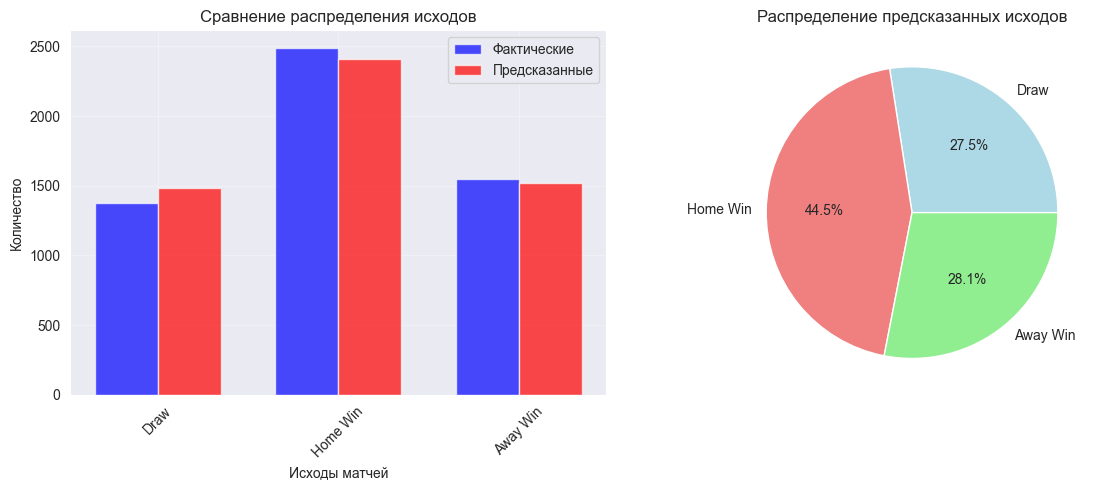

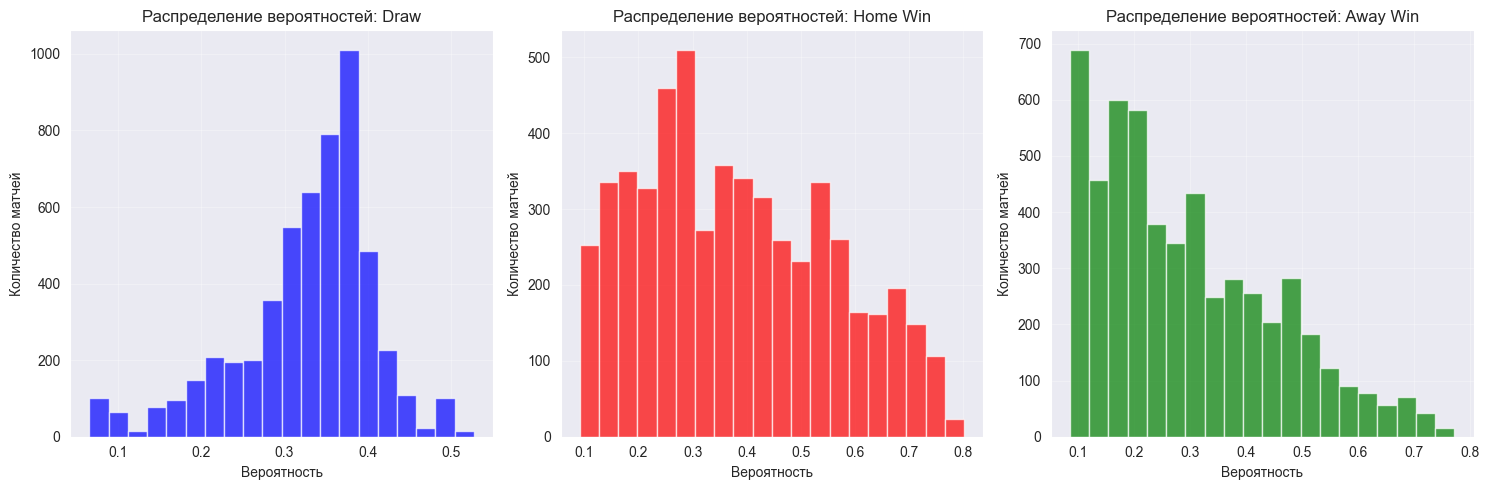

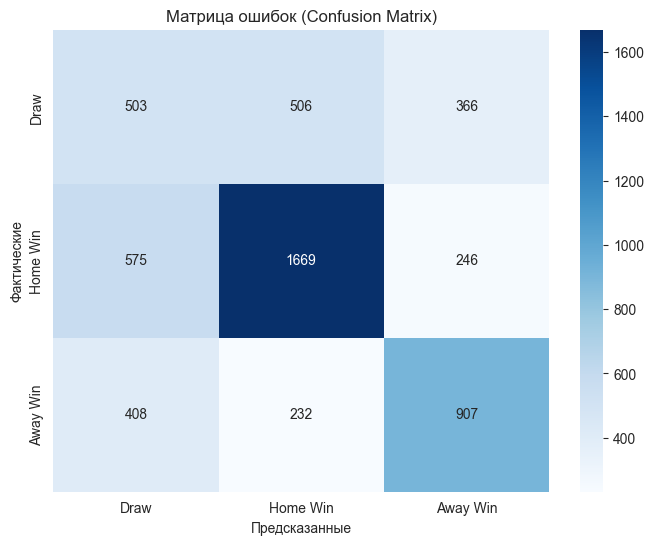


ДЕТАЛЬНАЯ СТАТИСТИКА ПРЕДСКАЗАНИЙ

Draw:
  Фактически: 1375 матчей (25.4%)
  Предсказано: 1486 матчей (27.5%)
  Разница: 2.1%

Home Win:
  Фактически: 2490 матчей (46.0%)
  Предсказано: 2407 матчей (44.5%)
  Разница: 1.5%

Away Win:
  Фактически: 1547 матчей (28.6%)
  Предсказано: 1519 матчей (28.1%)
  Разница: 0.5%

Снижение предсказаний ничьих: -8.1%

              precision    recall  f1-score   support

        Draw       0.34      0.37      0.35      1375
    Home Win       0.69      0.67      0.68      2490
    Away Win       0.60      0.59      0.59      1547

    accuracy                           0.57      5412
   macro avg       0.54      0.54      0.54      5412
weighted avg       0.58      0.57      0.57      5412



In [128]:
# --- ГРАФИКИ РАСПРЕДЕЛЕНИЯ ПРЕДСКАЗАННЫХ ИСХОДОВ ---

# Данные для графиков
actual_counts = np.bincount(y_test, minlength=3)
predicted_counts = np.bincount(y_class_pred, minlength=3)
class_names = ['Draw', 'Home Win', 'Away Win']  # ИСПРАВЛЕНО!

# 1. Столбчатая диаграмма - сравнение фактического и предсказанного распределения
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
x_pos = np.arange(len(class_names))
width = 0.35

plt.bar(x_pos - width / 2, actual_counts, width, label='Фактические', alpha=0.7, color='blue')
plt.bar(x_pos + width / 2, predicted_counts, width, label='Предсказанные', alpha=0.7, color='red')

plt.xlabel('Исходы матчей')
plt.ylabel('Количество')
plt.title('Сравнение распределения исходов')
plt.xticks(x_pos, class_names, rotation=45)
plt.legend()
plt.grid(alpha=0.3)

# 2. Круговая диаграмма предсказанных исходов
plt.subplot(1, 2, 2)
plt.pie(predicted_counts, labels=class_names, autopct='%1.1f%%', colors=['lightblue', 'lightcoral', 'lightgreen'])
plt.title('Распределение предсказанных исходов')

plt.tight_layout()
plt.show()

# 3. График вероятностей для каждого класса
plt.figure(figsize=(15, 5))

# Вероятности для каждого класса
for i, class_name in enumerate(class_names):
    plt.subplot(1, 3, i + 1)
    plt.hist(y_prob_pred[:, i], bins=20, alpha=0.7, color=['blue', 'red', 'green'][i])
    plt.xlabel('Вероятность')
    plt.ylabel('Количество матчей')
    plt.title(f'Распределение вероятностей: {class_name}')
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Heatmap матрицы ошибок

cm = confusion_matrix(y_test, y_class_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Предсказанные')
plt.ylabel('Фактические')
plt.title('Матрица ошибок (Confusion Matrix)')
plt.show()

# --- СТАТИСТИКА ---
print("\n" + "=" * 50)
print("ДЕТАЛЬНАЯ СТАТИСТИКА ПРЕДСКАЗАНИЙ")
print("=" * 50)

for i, class_name in enumerate(class_names):
    actual_perc = actual_counts[i] / len(y_test) * 100
    predicted_perc = predicted_counts[i] / len(y_class_pred) * 100

    print(f"\n{class_name}:")
    print(f"  Фактически: {actual_counts[i]} матчей ({actual_perc:.1f}%)")
    print(f"  Предсказано: {predicted_counts[i]} матчей ({predicted_perc:.1f}%)")
    print(f"  Разница: {abs(actual_perc - predicted_perc):.1f}%")

# Эффективность против ничьих (теперь ничьи - это класс 0)
draw_reduction = ((actual_counts[0] - predicted_counts[0]) / actual_counts[0] * 100)  # ИСПРАВЛЕНО!
print(f"\nСнижение предсказаний ничьих: {draw_reduction:.1f}%")

# Точность по классам

print("\n" + classification_report(y_test, y_class_pred, target_names=class_names))

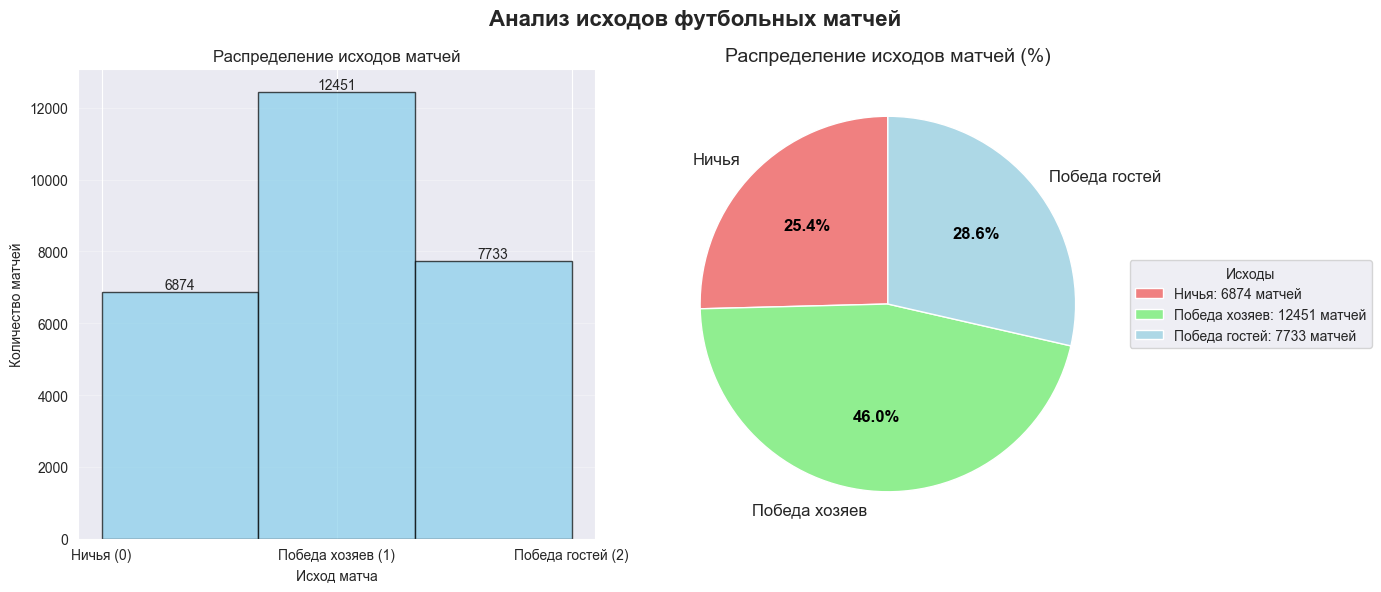

In [129]:
# ГРАФИКИ РАСПРЕДЕЛЕНИЯ РЕАЛЬНЫХ ИСХОДОВ
# Создаем фигуру с двумя subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# --- ГИСТОГРАММА (левый график) ---
counts, bins, patches = ax1.hist(df_final['who_win'], bins=3, edgecolor='black', alpha=0.7, color='skyblue')
ax1.set_xticks(ticks=[0, 1, 2])
ax1.set_xticklabels(['Ничья (0)', 'Победа хозяев (1)', 'Победа гостей (2)'])
ax1.set_xlabel('Исход матча')
ax1.set_ylabel('Количество матчей')
ax1.set_title('Распределение исходов матчей')
ax1.grid(axis='y', alpha=0.3)

# Добавляем числовые значения на столбцы гистограммы
for count, patch in zip(counts, patches):
    ax1.text(patch.get_x() + patch.get_width()/2, count + 0.5,
             str(int(count)), ha='center', va='bottom')

# --- КРУГОВАЯ ДИАГРАММА (правый график) ---
# Подсчитываем количество каждого исхода
outcome_counts = df_final['who_win'].value_counts().sort_index()
labels = ['Ничья', 'Победа хозяев', 'Победа гостей']
colors = ['lightcoral', 'lightgreen', 'lightblue']

# Строим круговую диаграмму с процентами
wedges, texts, autotexts = ax2.pie(outcome_counts,
                                   labels=labels,
                                   colors=colors,
                                   autopct='%1.1f%%',
                                   startangle=90,
                                   textprops={'fontsize': 12})

# Улучшаем отображение процентов
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontweight('bold')

ax2.set_title('Распределение исходов матчей (%)', fontsize=14)

# Добавляем легенду с абсолютными значениями
legend_labels = [f'{label}: {count} матчей' for label, count in zip(labels, outcome_counts)]
ax2.legend(wedges, legend_labels, title="Исходы", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Общий заголовок для двух графиков
plt.suptitle('Анализ исходов футбольных матчей', fontsize=16, fontweight='bold')

# Настраиваем отступы
plt.tight_layout()

# Показываем графики
plt.show()

# 7. Создание общей матрицы матчей
Создадим матрицу все со всеми и заполним ее последними значениями атрибутов из df_all_games, потом из них посчитаем все соотношения, которые нам нужны как уже делали

In [130]:

# Шаг 1: Получаем список всех уникальных команд из всего датасета
all_teams = pd.concat([
    df_all_games['home_team_long_name'],
    df_all_games['away_team_long_name']
]).unique()

print(f"Всего уникальных команд в датасете: {len(all_teams)}")

# Шаг 2: Создаем матрицу всех возможных пар команд
all_combinations = list(permutations(all_teams, 2))
matrix_df = pd.DataFrame(all_combinations, columns=['home_team_long_name', 'away_team_long_name'])

print(f"Создано {len(matrix_df)} возможных матчей (все со всеми)")

# Шаг 3: Функция для получения последних доступных атрибутов команды
def get_team_final_attributes(team_name):
    """Получает финальные (последние) атрибуты команды за весь период"""
    # Находим все матчи с участием команды
    team_matches = df_all_games[
        (df_all_games['home_team_long_name'] == team_name) |
        (df_all_games['away_team_long_name'] == team_name)
    ]

    if len(team_matches) == 0:
        return None

    # Берем самый последний матч команды
    latest_match = team_matches.sort_values('date_x').iloc[-1]

    # Определяем, была ли команда домашней или гостевой
    if latest_match['home_team_long_name'] == team_name:
        prefix = 'home_'
        league_strength = latest_match.get('home_team_league_strenght', 1.0)
    else:
        prefix = 'away_'
        league_strength = latest_match.get('away_team_league_strenght', 1.0)

    # Собираем все нужные атрибуты
    attributes = [
        'overall_rating',
        'buildupplayspeed_current_avg', 'buildupplaypassing_current_avg',
        'chancecreationpassing_current_avg', 'chancecreationshooting_current_avg',
        'chancecreationcrossing_current_avg', 'defencepressure_current_avg',
        'defenceaggression_current_avg', 'defenceteamwidth_current_avg',
        'buildupplayspeed_last_10_matches', 'buildupplaypassing_last_10_matches',
        'chancecreationpassing_last_10_matches', 'chancecreationshooting_last_10_matches',
        'chancecreationcrossing_last_10_matches', 'defencepressure_last_10_matches',
        'defenceaggression_last_10_matches', 'defenceteamwidth_last_10_matches',
        'last_5_games_pts', 'cum_pts_per_season'
    ]

    team_data = {}

    # Базовые атрибуты
    for attr in attributes:
        team_data[attr] = latest_match.get(f'{prefix}{attr}', np.nan)

    # Комбинированные атрибуты
    for attr in attributes:
        base_value = team_data.get(attr)
        if not pd.isna(base_value) and not pd.isna(league_strength):
            team_data[f'combined_{attr}'] = base_value * league_strength
        else:
            team_data[f'combined_{attr}'] = np.nan

    team_data['league_strength'] = league_strength

    return team_data

# Шаг 4: Создаем словарь с финальными атрибутами всех команд
print("Собираем финальные атрибуты всех команд...")
team_attributes = {}
for i, team in enumerate(all_teams):
    if i % 100 == 0:
        print(f"Обработано {i}/{len(all_teams)} команд")
    team_attributes[team] = get_team_final_attributes(team)

print("Сбор атрибутов завершен!")



Всего уникальных команд в датасете: 296
Создано 87320 возможных матчей (все со всеми)
Собираем финальные атрибуты всех команд...
Обработано 0/296 команд
Обработано 100/296 команд
Обработано 200/296 команд
Сбор атрибутов завершен!


In [131]:
# Шаг 5: Функция для расчета всех ratios для пары команд

# Считаем так же как мы делали для тестовоого датасета, но используем безопасные расчеты, чтобы потом не заменять нан везде.
def calculate_all_ratios(home_team, away_team):
    """Рассчитывает все ratios для пары домашняя-гостевая команда"""
    home_data = team_attributes.get(home_team, {})
    away_data = team_attributes.get(away_team, {})

    ratios = {}

    # Вспомогательная функция для безопасного расчета среднего
    def safe_mean(values):
        valid_values = [v for v in values if not pd.isna(v)]
        return np.mean(valid_values) if valid_values else np.nan

    # 1. Базовые ratios (без учета силы лиг)
    # buildup ratios
    home_buildup_avg = safe_mean([
        home_data.get('buildupplayspeed_current_avg'),
        home_data.get('buildupplaypassing_current_avg')
    ])
    away_buildup_avg = safe_mean([
        away_data.get('buildupplayspeed_current_avg'),
        away_data.get('buildupplaypassing_current_avg')
    ])
    ratios['buildup_ratio_avg'] = home_buildup_avg / away_buildup_avg if away_buildup_avg != 0 else np.nan

    home_buildup_l10 = safe_mean([
        home_data.get('buildupplayspeed_last_10_matches'),
        home_data.get('buildupplaypassing_last_10_matches')
    ])
    away_buildup_l10 = safe_mean([
        away_data.get('buildupplayspeed_last_10_matches'),
        away_data.get('buildupplaypassing_last_10_matches')
    ])
    ratios['buildup_ratio_l10'] = home_buildup_l10 / away_buildup_l10 if away_buildup_l10 != 0 else np.nan

    # attack/defense ratios
    home_attack_avg = safe_mean([
        home_data.get('chancecreationpassing_current_avg'),
        home_data.get('chancecreationshooting_current_avg'),
        home_data.get('chancecreationcrossing_current_avg')
    ])
    away_defense_avg = safe_mean([
        away_data.get('defencepressure_current_avg'),
        away_data.get('defenceaggression_current_avg'),
        away_data.get('defenceteamwidth_current_avg')
    ])
    ratios['attack_defense_ratio_avg'] = home_attack_avg / away_defense_avg if away_defense_avg != 0 else np.nan

    home_attack_l10 = safe_mean([
        home_data.get('chancecreationpassing_last_10_matches'),
        home_data.get('chancecreationshooting_last_10_matches'),
        home_data.get('chancecreationcrossing_last_10_matches')
    ])
    away_defense_l10 = safe_mean([
        away_data.get('defencepressure_last_10_matches'),
        away_data.get('defenceaggression_last_10_matches'),
        away_data.get('defenceteamwidth_last_10_matches')
    ])
    ratios['attack_defense_ratio_l10'] = home_attack_l10 / away_defense_l10 if away_defense_l10 != 0 else np.nan

    # defense/attack ratios
    home_defense_avg = safe_mean([
        home_data.get('defencepressure_current_avg'),
        home_data.get('defenceaggression_current_avg'),
        home_data.get('defenceteamwidth_current_avg')
    ])
    away_attack_avg = safe_mean([
        away_data.get('chancecreationpassing_current_avg'),
        away_data.get('chancecreationshooting_current_avg'),
        away_data.get('chancecreationcrossing_current_avg')
    ])
    ratios['defense_attack_ratio_avg'] = home_defense_avg / away_attack_avg if away_attack_avg != 0 else np.nan

    home_defense_l10 = safe_mean([
        home_data.get('defencepressure_last_10_matches'),
        home_data.get('defenceaggression_last_10_matches'),
        home_data.get('defenceteamwidth_last_10_matches')
    ])
    away_attack_l10 = safe_mean([
        away_data.get('chancecreationpassing_last_10_matches'),
        away_data.get('chancecreationshooting_last_10_matches'),
        away_data.get('chancecreationcrossing_last_10_matches')
    ])
    ratios['defense_attack_ratio_l10'] = home_defense_l10 / away_attack_l10 if away_attack_l10 != 0 else np.nan

    # Простые ratios
    ratios['overall_rating_ratio'] = home_data.get('overall_rating', np.nan) / away_data.get('overall_rating', np.nan) if away_data.get('overall_rating', 0) != 0 else np.nan
    ratios['last_5_games_pts_ratio'] = home_data.get('last_5_games_pts', np.nan) / away_data.get('last_5_games_pts', np.nan) if away_data.get('last_5_games_pts', 0) != 0 else np.nan
    ratios['cum_pts_ratio'] = home_data.get('cum_pts_per_season', np.nan) / away_data.get('cum_pts_per_season', np.nan) if away_data.get('cum_pts_per_season', 0) != 0 else np.nan

    # 2. Комбинированные ratios (с учетом силы лиг)
    # Combined buildup ratios
    home_combined_buildup_avg = safe_mean([
        home_data.get('combined_buildupplayspeed_current_avg'),
        home_data.get('combined_buildupplaypassing_current_avg')
    ])
    away_combined_buildup_avg = safe_mean([
        away_data.get('combined_buildupplayspeed_current_avg'),
        away_data.get('combined_buildupplaypassing_current_avg')
    ])
    ratios['combined_buildup_ratio_avg'] = home_combined_buildup_avg / away_combined_buildup_avg if away_combined_buildup_avg != 0 else np.nan

    home_combined_buildup_l10 = safe_mean([
        home_data.get('combined_buildupplayspeed_last_10_matches'),
        home_data.get('combined_buildupplaypassing_last_10_matches')
    ])
    away_combined_buildup_l10 = safe_mean([
        away_data.get('combined_buildupplayspeed_last_10_matches'),
        away_data.get('combined_buildupplaypassing_last_10_matches')
    ])
    ratios['combined_buildup_ratio_l10'] = home_combined_buildup_l10 / away_combined_buildup_l10 if away_combined_buildup_l10 != 0 else np.nan

    # Combined attack/defense ratios
    home_combined_attack_avg = safe_mean([
        home_data.get('combined_chancecreationpassing_current_avg'),
        home_data.get('combined_chancecreationshooting_current_avg'),
        home_data.get('combined_chancecreationcrossing_current_avg')
    ])
    away_combined_defense_avg = safe_mean([
        away_data.get('combined_defencepressure_current_avg'),
        away_data.get('combined_defenceaggression_current_avg'),
        away_data.get('combined_defenceteamwidth_current_avg')
    ])
    ratios['combined_attack_defense_ratio_avg'] = home_combined_attack_avg / away_combined_defense_avg if away_combined_defense_avg != 0 else np.nan

    home_combined_attack_l10 = safe_mean([
        home_data.get('combined_chancecreationpassing_last_10_matches'),
        home_data.get('combined_chancecreationshooting_last_10_matches'),
        home_data.get('combined_chancecreationcrossing_last_10_matches')
    ])
    away_combined_defense_l10 = safe_mean([
        away_data.get('combined_defencepressure_last_10_matches'),
        away_data.get('combined_defenceaggression_last_10_matches'),
        away_data.get('combined_defenceteamwidth_last_10_matches')
    ])
    ratios['combined_attack_defense_ratio_l10'] = home_combined_attack_l10 / away_combined_defense_l10 if away_combined_defense_l10 != 0 else np.nan

    # Combined defense/attack ratios
    home_combined_defense_avg = safe_mean([
        home_data.get('combined_defencepressure_current_avg'),
        home_data.get('combined_defenceaggression_current_avg'),
        home_data.get('combined_defenceteamwidth_current_avg')
    ])
    away_combined_attack_avg = safe_mean([
        away_data.get('combined_chancecreationpassing_current_avg'),
        away_data.get('combined_chancecreationshooting_current_avg'),
        away_data.get('combined_chancecreationcrossing_current_avg')
    ])
    ratios['combined_defense_attack_ratio_avg'] = home_combined_defense_avg / away_combined_attack_avg if away_combined_attack_avg != 0 else np.nan

    home_combined_defense_l10 = safe_mean([
        home_data.get('combined_defencepressure_last_10_matches'),
        home_data.get('combined_defenceaggression_last_10_matches'),
        home_data.get('combined_defenceteamwidth_last_10_matches')
    ])
    away_combined_attack_l10 = safe_mean([
        away_data.get('combined_chancecreationpassing_last_10_matches'),
        away_data.get('combined_chancecreationshooting_last_10_matches'),
        away_data.get('combined_chancecreationcrossing_last_10_matches')
    ])
    ratios['combined_defense_attack_ratio_l10'] = home_combined_defense_l10 / away_combined_attack_l10 if away_combined_attack_l10 != 0 else np.nan

    # Combined простые ratios
    ratios['combined_overall_rating_ratio'] = home_data.get('combined_overall_rating', np.nan) / away_data.get('combined_overall_rating', np.nan) if away_data.get('combined_overall_rating', 0) != 0 else np.nan
    ratios['combined_last_5_games_pts_ratio'] = home_data.get('combined_last_5_games_pts', np.nan) / away_data.get('combined_last_5_games_pts', np.nan) if away_data.get('combined_last_5_games_pts', 0) != 0 else np.nan
    ratios['combined_cum_pts_ratio'] = home_data.get('combined_cum_pts_per_season', np.nan) / away_data.get('combined_cum_pts_per_season', np.nan) if away_data.get('combined_cum_pts_per_season', 0) != 0 else np.nan

    return ratios



In [132]:
# Шаг 6: Применяем функцию расчета ratios ко всей матрице
print("Рассчитываем ratios для всех пар...")

# Разбиваем на части для обработки (чтобы не перегружать память)
chunk_size = 10000
matrix_chunks = [matrix_df[i:i + chunk_size] for i in range(0, len(matrix_df), chunk_size)]

all_ratios = []
for i, chunk in enumerate(matrix_chunks):
    print(f"Обрабатываю чанк {i+1}/{len(matrix_chunks)}")
    chunk_ratios = chunk.apply(
        lambda row: calculate_all_ratios(row['home_team_long_name'], row['away_team_long_name']),
        axis=1
    )
    all_ratios.append(pd.DataFrame(chunk_ratios.tolist()))

# Объединяем все ratios
ratios_df = pd.concat(all_ratios, ignore_index=True)

# Шаг 7: Объединяем с исходной матрицей
final_matrix = pd.concat([matrix_df, ratios_df], axis=1)

# Шаг 8: Обрабатываем пропущенные и бесконечные значения
def safe_divide_cleanup(df):
    """Безопасная обработка деления на ноль и бесконечностей"""
    for col in df.columns:
        if col.endswith('_ratio'):
            # Заменяем inf и -inf на NaN
            df[col] = df[col].replace([np.inf, -np.inf], np.nan)
            # Заполняем NaN средними значениями из тренировочных данных
            if col in X.columns:
                df[col] = df[col].fillna(X[col].mean())
            else:
                df[col] = df[col].fillna(1.0)  # нейтральное значение по умолчанию
    return df

final_matrix = safe_divide_cleanup(final_matrix)

print(f"Финальная матрица готова! Размер: {final_matrix.shape}")



Рассчитываем ratios для всех пар...
Обрабатываю чанк 1/9
Обрабатываю чанк 2/9
Обрабатываю чанк 3/9
Обрабатываю чанк 4/9
Обрабатываю чанк 5/9
Обрабатываю чанк 6/9
Обрабатываю чанк 7/9
Обрабатываю чанк 8/9
Обрабатываю чанк 9/9
Финальная матрица готова! Размер: (87320, 20)


# 8. Предсказываем результаты с помощью нашей модели

In [ ]:
# Шаг 9: Делаем предсказания с помощью обученной модели
print("Делаем предсказания для всей матрицы...")

# Убедимся, что у нас есть все нужные колонки
required_columns = [
    'buildup_ratio_avg', 'buildup_ratio_l10', 'attack_defense_ratio_avg',
    'attack_defense_ratio_l10', 'defense_attack_ratio_avg',
    'defense_attack_ratio_l10', 'overall_rating_ratio',
    'last_5_games_pts_ratio', 'cum_pts_ratio',
    'combined_buildup_ratio_avg', 'combined_buildup_ratio_l10',
    'combined_attack_defense_ratio_avg', 'combined_attack_defense_ratio_l10',
    'combined_defense_attack_ratio_avg', 'combined_defense_attack_ratio_l10',
    'combined_overall_rating_ratio', 'combined_last_5_games_pts_ratio',
    'combined_cum_pts_ratio'
]

# Проверяем наличие всех колонок
missing_cols = set(required_columns) - set(final_matrix.columns)
if missing_cols:
    print(f"Предупреждение: отсутствуют колонки: {missing_cols}")
    # Создаем недостающие колонки с нейтральными значениями
    for col in missing_cols:
        final_matrix[col] = 1.0  # нейтральное значение

# Делаем предсказания
predictions = best_model.predict_proba(final_matrix[required_columns])

# Добавляем предсказания в матрицу
final_matrix['prob_draw'] = predictions[:, 0]
final_matrix['prob_home_win'] = predictions[:, 1]
final_matrix['prob_away_win'] = predictions[:, 2]

# Определяем наиболее вероятный исход
final_matrix['predicted_outcome'] = np.argmax(predictions, axis=1)
final_matrix['predicted_outcome_name'] = final_matrix['predicted_outcome'].map({
    0: 'Draw', 1: 'Home Win', 2: 'Away Win'
})



# 9. Подготовка финального csv для дашборда
#### 9.1 Добавление названия Лиги

In [135]:
# В целом уже ок, но надо добавить лигу, чтобы было удобно искать

# определяем лигу

# Функция для быстрого определения лиги
def get_team_league_quick(team_name):
    """Быстро определяет лигу команды"""
    # Ищем последний не-UEFA матч команды
    team_matches = df_all_games[
        ((df_all_games['home_team_long_name'] == team_name) |
         (df_all_games['away_team_long_name'] == team_name)) &
        (df_all_games['league_name'] != 'UEFA')
    ]

    if len(team_matches) > 0:
        return team_matches.iloc[-1]['league_name']
    return 'Unknown'

# Добавляем лиги в матрицу
final_matrix['home_team_league'] = final_matrix['home_team_long_name'].apply(get_team_league_quick)
final_matrix['away_team_league'] = final_matrix['away_team_long_name'].apply(get_team_league_quick)

# Создаем компактную версию для дашборда
dashboard_cols = [
    'home_team_long_name', 'away_team_long_name',
    'prob_home_win', 'prob_draw', 'prob_away_win',
    'predicted_outcome_name'
]

# Добавляем базовые атрибуты команд для отображения
for team_type in ['home', 'away']:
    final_matrix[f'{team_type}_overall_rating'] = final_matrix[f'{team_type}_team_long_name'].map(
        lambda x: team_attributes.get(x, {}).get('overall_rating', np.nan)
    )
    final_matrix[f'{team_type}_last_5_pts'] = final_matrix[f'{team_type}_team_long_name'].map(
        lambda x: team_attributes.get(x, {}).get('last_5_games_pts', np.nan)
    )
    final_matrix[f'{team_type}_league_strength'] = final_matrix[f'{team_type}_team_long_name'].map(
        lambda x: team_attributes.get(x, {}).get('league_strength', np.nan)
    )
    dashboard_cols.extend([
        f'{team_type}_overall_rating',
        f'{team_type}_last_5_pts',
        f'{team_type}_league_strength'
    ])

print("Готово! Матрица всех со всеми создана успешно!")

Готово! Матрица всех со всеми создана успешно!


#### 9.2 Добавление характеристик для дашборда
Матрица собрана! Осталось собрать небольшой дф_характеристики в который для каждой команды посчитаем количество забитых голов за последние 5 матчей и количество пропущенных голов за последние 5 матчей

Сольем все в одну финальную матрицу, почистим от лишнего и на этом все

In [136]:

# Создаем копию данных для безопасности
df_team_char_last_5 = df_all_games.copy()

# Переименовываем колонки для ясности
if 'home_team_goal_x' in df_team_char_last_5.columns and 'away_team_goal_x' in df_team_char_last_5.columns:
    df_team_char_last_5 = df_team_char_last_5.rename(columns={
        'home_team_goal_x': 'home_team_goals',
        'away_team_goal_x': 'away_team_goals'
    })

# Создаем отдельные таблицы для домашних и гостевых команд
home_team_stats = df_team_char_last_5[['date_x', 'home_team_long_name', 'home_team_goals', 'away_team_goals']].copy()
away_team_stats = df_team_char_last_5[['date_x', 'away_team_long_name', 'away_team_goals', 'home_team_goals']].copy()

# Переименовываем колонки для унификации
home_team_stats.columns = ['date', 'team_long_name', 'goals_scored', 'goals_conceded']
away_team_stats.columns = ['date', 'team_long_name', 'goals_scored', 'goals_conceded']

# Объединяем домашние и гостевые матчи
all_team_stats = pd.concat([home_team_stats, away_team_stats], ignore_index=True)

# Сортируем по команде и дате (важно для корректного расчета последних 5 матчей)
all_team_stats = all_team_stats.sort_values(['team_long_name', 'date'])

# Используем agg для расчета статистики за последние 5 матчей
df_team_char_last_5 = all_team_stats.groupby('team_long_name').agg({
    'goals_scored': lambda x: x.tail(5).sum() if len(x) >= 5 else x.sum(),
    'goals_conceded': lambda x: x.tail(5).sum() if len(x) >= 5 else x.sum()
}).reset_index()

# Переименовываем колонки
df_team_char_last_5.columns = ['team_long_name', 'goals_scored_last_5', 'goals_conceded_last_5']

# Заполняем пропуски нулями (на всякий случай)
df_team_char_last_5 = df_team_char_last_5.fillna(0)

print("Статистика голов за последние 5 матчей создана!")
print(f"Размер датафрейма: {df_team_char_last_5.shape}")
df_team_char_last_5.head(10)


Статистика голов за последние 5 матчей создана!
Размер датафрейма: (296, 3)


,team_long_name,goals_scored_last_5,goals_conceded_last_5
0,1. FC Kaiserslautern,6,13
1,1. FC Köln,9,5
2,1. FC Nürnberg,3,16
3,1. FSV Mainz 05,6,6
4,AC Ajaccio,5,11
5,AC Arles-Avignon,5,7
6,AC Bellinzona,5,9
7,ADO Den Haag,7,6
8,AJ Auxerre,9,9
9,AS Monaco,9,10


In [137]:
final_matrix_for_tableau = final_matrix[['home_team_long_name', 'away_team_long_name',
       'prob_draw', 'prob_home_win', 'prob_away_win', 'predicted_outcome',
       'predicted_outcome_name', 'home_team_league', 'away_team_league',
        'home_last_5_pts', 'home_league_strength',
       'away_last_5_pts', 'away_league_strength']].copy()

In [138]:
# Добавляем данные для домашней команды
final_matrix_for_tableau = final_matrix_for_tableau.merge(
    df_team_char_last_5[['team_long_name', 'goals_scored_last_5', 'goals_conceded_last_5']],
    left_on='home_team_long_name',
    right_on='team_long_name',
    how='left'
).rename(columns={
    'goals_scored_last_5': 'home_goals_scored_last_5',
    'goals_conceded_last_5': 'home_goals_conceded_last_5'
}).drop('team_long_name', axis=1)  # Удаляем лишнюю колонку

# Добавляем данные для гостевой команды
final_matrix_for_tableau = final_matrix_for_tableau.merge(
    df_team_char_last_5[['team_long_name', 'goals_scored_last_5', 'goals_conceded_last_5']],
    left_on='away_team_long_name',
    right_on='team_long_name',
    how='left'
).rename(columns={
    'goals_scored_last_5': 'away_goals_scored_last_5',
    'goals_conceded_last_5': 'away_goals_conceded_last_5'
}).drop('team_long_name', axis=1)  # Удаляем лишнюю колонку

In [140]:
final_matrix_for_tableau

,home_team_long_name,away_team_long_name,prob_draw,prob_home_win,prob_away_win,predicted_outcome,predicted_outcome_name,home_team_league,away_team_league,home_last_5_pts,home_league_strength,away_last_5_pts,away_league_strength,home_goals_scored_last_5,home_goals_conceded_last_5,away_goals_scored_last_5,away_goals_conceded_last_5
0,BSC Young Boys,FC Aarau,0.213606,0.679922,0.106472,1,Home Win,Switzerland Super League,Switzerland Super League,9.0,33.775,3.0,34.275,12,7,6,10
1,BSC Young Boys,Neuchâtel Xamax,0.155518,0.755913,0.088569,1,Home Win,Switzerland Super League,Switzerland Super League,9.0,33.775,7.0,26.800,12,7,8,7
2,BSC Young Boys,FC Luzern,0.332093,0.488752,0.179155,1,Home Win,Switzerland Super League,Switzerland Super League,9.0,33.775,13.0,33.775,12,7,15,4
3,BSC Young Boys,FC Basel,0.393661,0.259843,0.346496,0,Draw,Switzerland Super League,Switzerland Super League,9.0,33.775,10.0,33.775,12,7,7,10
4,BSC Young Boys,AC Bellinzona,0.200684,0.669710,0.129606,1,Home Win,Switzerland Super League,Switzerland Super League,9.0,33.775,1.0,24.900,12,7,5,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87315,UD Las Palmas,Uniao da Madeira,0.311100,0.569105,0.119795,1,Home Win,Spain LIGA BBVA,Portugal Liga ZON Sagres,5.0,107.713,3.0,53.082,7,8,7,10
87316,UD Las Palmas,GFC Ajaccio,0.274961,0.614511,0.110528,1,Home Win,Spain LIGA BBVA,France Ligue 1,5.0,107.713,4.0,52.749,7,8,6,13
87317,UD Las Palmas,FC Ingolstadt 04,0.310220,0.515929,0.173850,1,Home Win,Spain LIGA BBVA,Germany 1. Bundesliga,5.0,107.713,4.0,80.177,7,8,6,11
87318,UD Las Palmas,Frosinone,0.268569,0.622402,0.109029,1,Home Win,Spain LIGA BBVA,Italy Serie A,5.0,107.713,4.0,70.439,7,8,4,15


In [141]:
final_matrix_for_tableau = final_matrix_for_tableau[['home_team_long_name', 'away_team_long_name', 'home_team_league', 'away_team_league', 'prob_draw',
       'prob_home_win', 'prob_away_win', 'predicted_outcome',
       'predicted_outcome_name',
       'home_last_5_pts', 'away_last_5_pts', 'home_goals_scored_last_5',
       'home_goals_conceded_last_5', 'away_goals_scored_last_5',
       'away_goals_conceded_last_5', 'home_league_strength',
       'away_league_strength']]

In [142]:
final_matrix_for_tableau.to_csv('/data/final_matrix_for_tableau.csv')